# Import Libraries
- Python libraries and packages used in this study
- Connecting users' google drive to the notebook

In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import imblearn
print(imblearn.__version__)

0.10.1


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import seaborn as sns
import statistics
import math as m

# import necessary packages
import pandas as pd
from copy import deepcopy as copy
import numpy as np
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from sklearn import datasets
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE
from collections import Counter



In [ ]:
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/My Drive/THESIS/Methodology/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Balancing the Data & BPNN Preparation
- Downsampling data: to remove unbuildable areas
- Upsampling data: generate data points with '1' label (just to teach the model)
- Dataframe set up: normalizing data
- Dataframes: Filtering low accessible areas (to get potential areas to put up an RHU on)

## Downsampling: remove unbuildable areas

In [ ]:
sablayan_clustered_df = pd.read_csv(data_dir + 'HCFAI_Cluster_data.csv')
sablayan_clustered_df

,Unnamed: 0,Unnamed: 0.1,id,BARANGAY,PSGC,LAND COVERAGE,RHU,POPULATION DENSITY PER HEXAGON,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,LANDCOVER NUMERICAL,HCFAI_x,TargetID,Distance in kilometers,POPULATION PER HEX,HCFAI_y,Cluster
0,0,0,22,Ligaya,PH175109009,Brush/Shrubs,0,0.000000,1,1,0,0,2.0,1,0.284618,93,3.300139,0.000000,0.284618,0
1,1,1,23,Burgos,PH175109009,Brush/Shrubs,0,0.000000,0,0,0,0,2.0,1,0.274238,93,2.858004,0.000000,0.274238,0
2,2,2,49,Pag-Asa,PH175109004,NaN,0,154.538807,0,0,3,2,0.0,0,0.297160,366,13.097064,1093.052985,0.297160,0
3,3,3,50,San Agustin,PH175109004,Built Up,0,214.812672,0,0,3,2,0.0,0,0.320398,93,12.457756,1519.370031,0.320398,0
4,4,4,51,San Agustin,PH175109004,Grassland,0,302.902705,0,0,3,1,0.0,1,0.341248,93,10.820233,2142.430830,0.341248,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,967,1393,1362,Pag-Asa,PH175109003,Open Forest,0,8.598491,0,0,0,0,3.0,0,0.269338,311,42.902044,60.817128,0.269338,0
968,968,1395,1363,Pag-Asa,PH175109003,Brush/Shrubs,0,16.884621,0,0,0,0,3.0,1,0.269869,311,42.997136,119.424927,0.269869,0
969,969,1397,1364,Pag-Asa,PH175109003,NaN,0,21.536779,0,0,0,0,3.0,0,0.270403,311,43.155156,152.329636,0.270403,0
970,970,1399,1397,Pag-Asa,PH175109003,NaN,0,0.000000,0,0,0,0,3.0,0,0.269337,311,44.368391,0.000000,0.269337,0


In [ ]:
# sablayan_clustered_df = sablayan_clustered_df.drop(['c', 'b', 'feasiblity', 'coverage', 'hci', 'HCFAI_x'], axis=1)
sablayan_clustered_df = sablayan_clustered_df.drop(['HCFAI_x'], axis=1)
sablayan_clustered_df.rename(columns = {'HCFAI_y':'HCFAI'}, inplace = True)
sablayan_clustered_df['Cluster'].unique()

array([0, 1])

In [ ]:
hex_with_rhu = sablayan_clustered_df[sablayan_clustered_df['RHU'] == 1]
print(hex_with_rhu)

     Unnamed: 0  Unnamed: 0.1   id      BARANGAY         PSGC LAND COVERAGE  \
16           16            18   93  Batong Buhay  PH175109002      Built Up   
133         133           177  311       Pag-Asa  PH175109008      Built Up   
157         157           211  366        Burgos  PH175109011        barren   

     RHU  POPULATION DENSITY PER HEXAGON  POIs PER HEXAGON  ROADS  \
16     1                     1590.110229                47      1   
133    1                      203.314786                 5      1   
157    1                      233.181617                 0      1   

     STORM SURGE HAZARD LEVEL  FLOOD HAZARD LEVEL  LANDSLIDE HAZARD LEVEL  \
16                          3                   2                     1.0   
133                         2                   0                     0.0   
157                         0                   3                     3.0   

     LANDCOVER NUMERICAL  TargetID  Distance in kilometers  \
16                     0        93 

In [ ]:
sablayan_clustered_df[sablayan_clustered_df['LANDCOVER NUMERICAL'] == 0]

,Unnamed: 0,Unnamed: 0.1,id,BARANGAY,PSGC,LAND COVERAGE,RHU,POPULATION DENSITY PER HEXAGON,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,LANDCOVER NUMERICAL,TargetID,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster
2,2,2,49,Pag-Asa,PH175109004,NaN,0,154.538807,0,0,3,2,0.0,0,366,13.097064,1093.052985,0.297160,0
3,3,3,50,San Agustin,PH175109004,Built Up,0,214.812672,0,0,3,2,0.0,0,93,12.457756,1519.370031,0.320398,0
5,5,5,58,Burgos,PH175109009,Built Up,0,1243.892810,13,1,3,2,2.0,0,93,1.650070,8798.053845,0.333032,0
6,6,6,59,Burgos,PH175109009,NaN,0,0.000000,0,0,3,2,2.0,0,93,2.858005,0.000000,0.268942,0
7,7,7,84,San Agustin,PH175109004,Annual Crop,0,82.983351,0,0,3,2,0.0,0,366,11.898864,586.941241,0.270957,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,966,1392,1361,Pag-Asa,PH175109003,Open Forest,0,7.618140,0,0,0,0,3.0,0,311,42.870300,53.883107,0.269338,0
967,967,1393,1362,Pag-Asa,PH175109003,Open Forest,0,8.598491,0,0,0,0,3.0,0,311,42.902044,60.817128,0.269338,0
969,969,1397,1364,Pag-Asa,PH175109003,NaN,0,21.536779,0,0,0,0,3.0,0,311,43.155156,152.329636,0.270403,0
970,970,1399,1397,Pag-Asa,PH175109003,NaN,0,0.000000,0,0,0,0,3.0,0,311,44.368391,0.000000,0.269337,0


In [ ]:
print(sablayan_clustered_df.shape)
print(sablayan_clustered_df['RHU'].unique())
print(sablayan_clustered_df['Cluster'].unique())
buildable = sablayan_clustered_df[sablayan_clustered_df['RHU'] == 1]
buildable

(972, 19)
[0 1]
[0 1]


,Unnamed: 0,Unnamed: 0.1,id,BARANGAY,PSGC,LAND COVERAGE,RHU,POPULATION DENSITY PER HEXAGON,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,LANDCOVER NUMERICAL,TargetID,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster
16,16,18,93,Batong Buhay,PH175109002,Built Up,1,1590.110229,47,1,3,2,1.0,0,93,0.0,11246.849650,0.720001,1
133,133,177,311,Pag-Asa,PH175109008,Built Up,1,203.314786,5,1,2,0,0.0,0,311,0.0,1438.045483,0.328209,0
157,157,211,366,Burgos,PH175109011,barren,1,233.181617,0,1,0,3,3.0,0,366,0.0,1649.293578,0.268943,0


### Changed LandCov value to 1 to rows where 'Cluster'==1 to avoid smote erorrs
1. Filter cluster == 1
2. Change row value to land cov == 1

In [ ]:
high_clustered = sablayan_clustered_df[sablayan_clustered_df['Cluster'] == 1]
high_clustered
# # use index to change row values
sablayan_clustered_df.loc[16, ['LANDCOVER NUMERICAL']] = [1]
sablayan_clustered_df.loc[85, ['LANDCOVER NUMERICAL']] = [1]
# sablayan_clustered_df.loc[16]
# sablayan_clustered_df.loc[85]
# sablayan_clustered_df[sablayan_clustered_df['Cluster'] == 1]

In [ ]:
non_buildable = sablayan_clustered_df[sablayan_clustered_df['LANDCOVER NUMERICAL'] == 0]
''' DROP NON BUILDABLE'''
# sablayan_clustered_df = sablayan_clustered_df.drop(non_buildable, axis = 0)
# sablayan_clustered_df = sablayan_clustered_df[sablayan_clustered_df['LANDCOVER NUMERICAL'] == 0]

sablayan_clustered_df.drop(sablayan_clustered_df.index[sablayan_clustered_df['LANDCOVER NUMERICAL'] == 0], inplace = True)

In [ ]:
sablayan_clustered_df

,Unnamed: 0,Unnamed: 0.1,id,BARANGAY,PSGC,LAND COVERAGE,RHU,POPULATION DENSITY PER HEXAGON,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,LANDCOVER NUMERICAL,TargetID,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster
0,0,0,22,Ligaya,PH175109009,Brush/Shrubs,0,0.000000,1,1,0,0,2.0,1,93,3.300139,0.000000,0.284618,0
1,1,1,23,Burgos,PH175109009,Brush/Shrubs,0,0.000000,0,0,0,0,2.0,1,93,2.858004,0.000000,0.274238,0
4,4,4,51,San Agustin,PH175109004,Grassland,0,302.902705,0,0,3,1,0.0,1,93,10.820233,2142.430830,0.341248,0
11,11,12,88,Batong Buhay,PH175109004,Brush/Shrubs,0,168.775302,0,0,3,2,0.0,1,366,11.898864,1193.747713,0.297111,0
12,12,14,89,Malisbong,PH175109004,Brush/Shrubs,0,239.737270,0,0,3,3,0.0,1,93,6.600283,1695.661709,0.286195,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,956,1380,1327,Burgos,PH175109003,Brush/Shrubs,0,8.342944,0,0,0,0,3.0,1,311,41.515148,59.009644,0.269663,0
957,957,1382,1328,Pag-Asa,PH175109003,Brush/Shrubs,0,9.566134,0,0,0,0,3.0,1,311,41.646111,67.661267,0.269663,0
964,964,1390,1359,Pag-Asa,PH175109008,Brush/Shrubs,0,8.042470,0,0,0,0,3.0,1,311,42.997136,56.884392,0.269663,0
965,965,1391,1360,Pag-Asa,PH175109008,Brush/Shrubs,0,8.922136,0,0,0,0,3.0,1,311,42.902044,63.106267,0.269663,0


In [ ]:
non_buildable.shape

(557, 19)

In [ ]:
sablayan_clustered_df

,Unnamed: 0,Unnamed: 0.1,id,BARANGAY,PSGC,LAND COVERAGE,RHU,POPULATION DENSITY PER HEXAGON,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,LANDCOVER NUMERICAL,TargetID,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster
0,0,0,22,Ligaya,PH175109009,Brush/Shrubs,0,0.000000,1,1,0,0,2.0,1,93,3.300139,0.000000,0.284618,0
1,1,1,23,Burgos,PH175109009,Brush/Shrubs,0,0.000000,0,0,0,0,2.0,1,93,2.858004,0.000000,0.274238,0
4,4,4,51,San Agustin,PH175109004,Grassland,0,302.902705,0,0,3,1,0.0,1,93,10.820233,2142.430830,0.341248,0
11,11,12,88,Batong Buhay,PH175109004,Brush/Shrubs,0,168.775302,0,0,3,2,0.0,1,366,11.898864,1193.747713,0.297111,0
12,12,14,89,Malisbong,PH175109004,Brush/Shrubs,0,239.737270,0,0,3,3,0.0,1,93,6.600283,1695.661709,0.286195,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,956,1380,1327,Burgos,PH175109003,Brush/Shrubs,0,8.342944,0,0,0,0,3.0,1,311,41.515148,59.009644,0.269663,0
957,957,1382,1328,Pag-Asa,PH175109003,Brush/Shrubs,0,9.566134,0,0,0,0,3.0,1,311,41.646111,67.661267,0.269663,0
964,964,1390,1359,Pag-Asa,PH175109008,Brush/Shrubs,0,8.042470,0,0,0,0,3.0,1,311,42.997136,56.884392,0.269663,0
965,965,1391,1360,Pag-Asa,PH175109008,Brush/Shrubs,0,8.922136,0,0,0,0,3.0,1,311,42.902044,63.106267,0.269663,0


In [ ]:
print(sablayan_clustered_df['RHU'].unique())

[0 1]


In [ ]:
sablayan_clustered_df = sablayan_clustered_df.reset_index(drop=True)

In [ ]:
sablayan_clustered_df

,Unnamed: 0,Unnamed: 0.1,id,BARANGAY,PSGC,LAND COVERAGE,RHU,POPULATION DENSITY PER HEXAGON,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,LANDCOVER NUMERICAL,TargetID,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster
0,0,0,22,Ligaya,PH175109009,Brush/Shrubs,0,0.000000,1,1,0,0,2.0,1,93,3.300139,0.000000,0.284618,0
1,1,1,23,Burgos,PH175109009,Brush/Shrubs,0,0.000000,0,0,0,0,2.0,1,93,2.858004,0.000000,0.274238,0
2,4,4,51,San Agustin,PH175109004,Grassland,0,302.902705,0,0,3,1,0.0,1,93,10.820233,2142.430830,0.341248,0
3,11,12,88,Batong Buhay,PH175109004,Brush/Shrubs,0,168.775302,0,0,3,2,0.0,1,366,11.898864,1193.747713,0.297111,0
4,12,14,89,Malisbong,PH175109004,Brush/Shrubs,0,239.737270,0,0,3,3,0.0,1,93,6.600283,1695.661709,0.286195,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,956,1380,1327,Burgos,PH175109003,Brush/Shrubs,0,8.342944,0,0,0,0,3.0,1,311,41.515148,59.009644,0.269663,0
411,957,1382,1328,Pag-Asa,PH175109003,Brush/Shrubs,0,9.566134,0,0,0,0,3.0,1,311,41.646111,67.661267,0.269663,0
412,964,1390,1359,Pag-Asa,PH175109008,Brush/Shrubs,0,8.042470,0,0,0,0,3.0,1,311,42.997136,56.884392,0.269663,0
413,965,1391,1360,Pag-Asa,PH175109008,Brush/Shrubs,0,8.922136,0,0,0,0,3.0,1,311,42.902044,63.106267,0.269663,0


## Dataframe Set-up

### Removing unneccessary columns from Revision HCFAI Computations

In [ ]:
# sablayan_clustered_df = sablayan_clustered_df.drop(sablayan_clustered_df.index[412]) # why do we do this again?
sablayan_clustered_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'BARANGAY', 'PSGC', 'LAND COVERAGE',
       'RHU', 'POPULATION DENSITY PER HEXAGON', 'POIs PER HEXAGON', 'ROADS',
       'STORM SURGE HAZARD LEVEL', 'FLOOD HAZARD LEVEL',
       'LANDSLIDE HAZARD LEVEL', 'LANDCOVER NUMERICAL', 'TargetID',
       'Distance in kilometers', 'POPULATION PER HEX', 'HCFAI', 'Cluster'],
      dtype='object')

### Getting the minimum distance

In [ ]:
sablayan_clustered_df = sablayan_clustered_df.dropna().reset_index(drop=True)
sablayan_clustered_df

,Unnamed: 0,Unnamed: 0.1,id,BARANGAY,PSGC,LAND COVERAGE,RHU,POPULATION DENSITY PER HEXAGON,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,LANDCOVER NUMERICAL,TargetID,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster
0,0,0,22,Ligaya,PH175109009,Brush/Shrubs,0,0.000000,1,1,0,0,2.0,1,93,3.300139,0.000000,0.284618,0
1,1,1,23,Burgos,PH175109009,Brush/Shrubs,0,0.000000,0,0,0,0,2.0,1,93,2.858004,0.000000,0.274238,0
2,4,4,51,San Agustin,PH175109004,Grassland,0,302.902705,0,0,3,1,0.0,1,93,10.820233,2142.430830,0.341248,0
3,11,12,88,Batong Buhay,PH175109004,Brush/Shrubs,0,168.775302,0,0,3,2,0.0,1,366,11.898864,1193.747713,0.297111,0
4,12,14,89,Malisbong,PH175109004,Brush/Shrubs,0,239.737270,0,0,3,3,0.0,1,93,6.600283,1695.661709,0.286195,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,956,1380,1327,Burgos,PH175109003,Brush/Shrubs,0,8.342944,0,0,0,0,3.0,1,311,41.515148,59.009644,0.269663,0
411,957,1382,1328,Pag-Asa,PH175109003,Brush/Shrubs,0,9.566134,0,0,0,0,3.0,1,311,41.646111,67.661267,0.269663,0
412,964,1390,1359,Pag-Asa,PH175109008,Brush/Shrubs,0,8.042470,0,0,0,0,3.0,1,311,42.997136,56.884392,0.269663,0
413,965,1391,1360,Pag-Asa,PH175109008,Brush/Shrubs,0,8.922136,0,0,0,0,3.0,1,311,42.902044,63.106267,0.269663,0


### Dropping Population Density == 0 and HCFAI column

In [ ]:
sablayan_clustered_df.loc[sablayan_clustered_df['POPULATION DENSITY PER HEXAGON'] == 0.000000]

,Unnamed: 0,Unnamed: 0.1,id,BARANGAY,PSGC,LAND COVERAGE,RHU,POPULATION DENSITY PER HEXAGON,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,LANDCOVER NUMERICAL,TargetID,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster
0,0,0,22,Ligaya,PH175109009,Brush/Shrubs,0,0.0,1,1,0,0,2.0,1,93,3.300139,0.0,0.284618,0
1,1,1,23,Burgos,PH175109009,Brush/Shrubs,0,0.0,0,0,0,0,2.0,1,93,2.858004,0.0,0.274238,0


In [ ]:
sablayan_clustered_df.drop(sablayan_clustered_df[sablayan_clustered_df['POPULATION DENSITY PER HEXAGON'] == 0.000000].index, inplace = True)

In [ ]:
sablayan_clustered_df

,Unnamed: 0,Unnamed: 0.1,id,BARANGAY,PSGC,LAND COVERAGE,RHU,POPULATION DENSITY PER HEXAGON,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,LANDCOVER NUMERICAL,TargetID,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster
2,4,4,51,San Agustin,PH175109004,Grassland,0,302.902705,0,0,3,1,0.0,1,93,10.820233,2142.430830,0.341248,0
3,11,12,88,Batong Buhay,PH175109004,Brush/Shrubs,0,168.775302,0,0,3,2,0.0,1,366,11.898864,1193.747713,0.297111,0
4,12,14,89,Malisbong,PH175109004,Brush/Shrubs,0,239.737270,0,0,3,3,0.0,1,93,6.600283,1695.661709,0.286195,0
5,16,18,93,Batong Buhay,PH175109002,Built Up,1,1590.110229,47,1,3,2,1.0,1,93,0.000000,11246.849650,0.720001,1
6,18,21,95,Pag-Asa,PH175109009,Brush/Shrubs,0,181.431633,1,1,3,1,2.0,1,93,3.300142,1283.265940,0.269228,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,956,1380,1327,Burgos,PH175109003,Brush/Shrubs,0,8.342944,0,0,0,0,3.0,1,311,41.515148,59.009644,0.269663,0
411,957,1382,1328,Pag-Asa,PH175109003,Brush/Shrubs,0,9.566134,0,0,0,0,3.0,1,311,41.646111,67.661267,0.269663,0
412,964,1390,1359,Pag-Asa,PH175109008,Brush/Shrubs,0,8.042470,0,0,0,0,3.0,1,311,42.997136,56.884392,0.269663,0
413,965,1391,1360,Pag-Asa,PH175109008,Brush/Shrubs,0,8.922136,0,0,0,0,3.0,1,311,42.902044,63.106267,0.269663,0


### Removing non-numeric data

In [ ]:
sablayan_clustered_df.rename(columns = {'Accessibility':'Cluster'}, inplace = True)
# sablayan_clustered_df = sablayan_clustered_df.replace(['LOW'],int(0))
# sablayan_clustered_df = sablayan_clustered_df.replace(['HIGH'],int(1))

In [ ]:
edited_df = sablayan_clustered_df.drop(['BARANGAY', 'PSGC', 'Unnamed: 0.1', 'POPULATION DENSITY PER HEXAGON', 'LAND COVERAGE', 'Unnamed: 0'], axis=1)
# , 'Cluster'

In [ ]:
edited_df.Cluster.unique()

array([0, 1])

In [ ]:
edited_df

,id,RHU,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,LANDCOVER NUMERICAL,TargetID,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster
2,51,0,0,0,3,1,0.0,1,93,10.820233,2142.430830,0.341248,0
3,88,0,0,0,3,2,0.0,1,366,11.898864,1193.747713,0.297111,0
4,89,0,0,0,3,3,0.0,1,93,6.600283,1695.661709,0.286195,0
5,93,1,47,1,3,2,1.0,1,93,0.000000,11246.849650,0.720001,1
6,95,0,1,1,3,1,2.0,1,93,3.300142,1283.265940,0.269228,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,1327,0,0,0,0,0,3.0,1,311,41.515148,59.009644,0.269663,0
411,1328,0,0,0,0,0,3.0,1,311,41.646111,67.661267,0.269663,0
412,1359,0,0,0,0,0,3.0,1,311,42.997136,56.884392,0.269663,0
413,1360,0,0,0,0,0,3.0,1,311,42.902044,63.106267,0.269663,0


In [ ]:
# edited_df.rename(columns = {'Unnamed: 15':'Cluster'}, inplace = True)

In [ ]:
# # Removing mid values in Cluster column
# # 1. Remove rows with Cluter values of 1
# # 2. Rename clusters 2 to 1
# edited_df.drop(edited_df[edited_df['Cluster'] == 1].index, inplace = True)
# edited_df['Cluster'] = edited_df['Cluster'].replace(2, 1)
# edited_df


In [ ]:
# searching for values within a pandas dataframe
# if nan, replace with 0
df1 = edited_df[edited_df.isna().any(axis=1)]
df1

,id,RHU,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,LANDCOVER NUMERICAL,TargetID,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster


In [ ]:
edited_df = edited_df.fillna(0)
edited_df

,id,RHU,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,LANDCOVER NUMERICAL,TargetID,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster
2,51,0,0,0,3,1,0.0,1,93,10.820233,2142.430830,0.341248,0
3,88,0,0,0,3,2,0.0,1,366,11.898864,1193.747713,0.297111,0
4,89,0,0,0,3,3,0.0,1,93,6.600283,1695.661709,0.286195,0
5,93,1,47,1,3,2,1.0,1,93,0.000000,11246.849650,0.720001,1
6,95,0,1,1,3,1,2.0,1,93,3.300142,1283.265940,0.269228,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,1327,0,0,0,0,0,3.0,1,311,41.515148,59.009644,0.269663,0
411,1328,0,0,0,0,0,3.0,1,311,41.646111,67.661267,0.269663,0
412,1359,0,0,0,0,0,3.0,1,311,42.997136,56.884392,0.269663,0
413,1360,0,0,0,0,0,3.0,1,311,42.902044,63.106267,0.269663,0


## Saving Ids in a different dataframe

In [ ]:
# Making id_template for retrieving hex id numbers in the future
id_template = edited_df.astype({'id' : 'int'})
id_template = id_template.filter(['id'])
id_template

,id
2,51
3,88
4,89
5,93
6,95
...,...
410,1327
411,1328
412,1359
413,1360


In [ ]:
y_sample_id = edited_df.filter(['id', 'Cluster'])

In [ ]:
y_sample_id

,id,Cluster
2,51,0
3,88,0
4,89,0
5,93,1
6,95,0
...,...,...
410,1327,0
411,1328,0
412,1359,0
413,1360,0


In [ ]:
edited_df = edited_df.drop(['id', 'TargetID'], axis=1)

In [ ]:
print(sablayan_clustered_df['RHU'].unique())

[0 1]


In [ ]:
x = edited_df.loc[:, ~edited_df.columns.isin(['RHU', 'LANDCOVER NUMERICAL'])]
x_normalized = (x - x.min()) / (x.max() - x.min())
x_normalized

,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster
2,0.000000,0.0,1.0,0.333333,0.000000,0.251650,0.189406,0.160302,0.0
3,0.000000,0.0,1.0,0.666667,0.000000,0.276736,0.104942,0.062451,0.0
4,0.000000,0.0,1.0,1.000000,0.000000,0.153505,0.149629,0.038250,0.0
5,1.000000,1.0,1.0,0.666667,0.333333,0.000000,1.000000,1.000000,1.0
6,0.021277,1.0,1.0,0.333333,0.666667,0.076753,0.112912,0.000634,0.0
...,...,...,...,...,...,...,...,...,...
410,0.000000,0.0,0.0,0.000000,1.000000,0.965533,0.003912,0.001598,0.0
411,0.000000,0.0,0.0,0.000000,1.000000,0.968579,0.004683,0.001599,0.0
412,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.003723,0.001598,0.0
413,0.000000,0.0,0.0,0.000000,1.000000,0.997788,0.004277,0.001599,0.0


In [ ]:
x_normalized['RHU'] = edited_df['RHU']
x_normalized['LANDCOVER NUMERICAL'] = edited_df['LANDCOVER NUMERICAL']
x_normalized

,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster,RHU,LANDCOVER NUMERICAL
2,0.000000,0.0,1.0,0.333333,0.000000,0.251650,0.189406,0.160302,0.0,0,1
3,0.000000,0.0,1.0,0.666667,0.000000,0.276736,0.104942,0.062451,0.0,0,1
4,0.000000,0.0,1.0,1.000000,0.000000,0.153505,0.149629,0.038250,0.0,0,1
5,1.000000,1.0,1.0,0.666667,0.333333,0.000000,1.000000,1.000000,1.0,1,1
6,0.021277,1.0,1.0,0.333333,0.666667,0.076753,0.112912,0.000634,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
410,0.000000,0.0,0.0,0.000000,1.000000,0.965533,0.003912,0.001598,0.0,0,1
411,0.000000,0.0,0.0,0.000000,1.000000,0.968579,0.004683,0.001599,0.0,0,1
412,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.003723,0.001598,0.0,0,1
413,0.000000,0.0,0.0,0.000000,1.000000,0.997788,0.004277,0.001599,0.0,0,1


In [ ]:
all_normalized = x_normalized
all_normalized

,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster,RHU,LANDCOVER NUMERICAL
2,0.000000,0.0,1.0,0.333333,0.000000,0.251650,0.189406,0.160302,0.0,0,1
3,0.000000,0.0,1.0,0.666667,0.000000,0.276736,0.104942,0.062451,0.0,0,1
4,0.000000,0.0,1.0,1.000000,0.000000,0.153505,0.149629,0.038250,0.0,0,1
5,1.000000,1.0,1.0,0.666667,0.333333,0.000000,1.000000,1.000000,1.0,1,1
6,0.021277,1.0,1.0,0.333333,0.666667,0.076753,0.112912,0.000634,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
410,0.000000,0.0,0.0,0.000000,1.000000,0.965533,0.003912,0.001598,0.0,0,1
411,0.000000,0.0,0.0,0.000000,1.000000,0.968579,0.004683,0.001599,0.0,0,1
412,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.003723,0.001598,0.0,0,1
413,0.000000,0.0,0.0,0.000000,1.000000,0.997788,0.004277,0.001599,0.0,0,1


In [ ]:
# Remove column name 'A' and 'RHU'
x_normalized = x_normalized.drop(['Cluster'], axis=1)
x_normalized

,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,Distance in kilometers,POPULATION PER HEX,HCFAI,RHU,LANDCOVER NUMERICAL
2,0.000000,0.0,1.0,0.333333,0.000000,0.251650,0.189406,0.160302,0,1
3,0.000000,0.0,1.0,0.666667,0.000000,0.276736,0.104942,0.062451,0,1
4,0.000000,0.0,1.0,1.000000,0.000000,0.153505,0.149629,0.038250,0,1
5,1.000000,1.0,1.0,0.666667,0.333333,0.000000,1.000000,1.000000,1,1
6,0.021277,1.0,1.0,0.333333,0.666667,0.076753,0.112912,0.000634,0,1
...,...,...,...,...,...,...,...,...,...,...
410,0.000000,0.0,0.0,0.000000,1.000000,0.965533,0.003912,0.001598,0,1
411,0.000000,0.0,0.0,0.000000,1.000000,0.968579,0.004683,0.001599,0,1
412,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.003723,0.001598,0,1
413,0.000000,0.0,0.0,0.000000,1.000000,0.997788,0.004277,0.001599,0,1


In [ ]:
y_df = edited_df['Cluster'].values
y_df

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
num_features = len(x_normalized.columns)
print("Number of Features: {}".format(num_features))

Number of Features: 10


In [ ]:
columns = []

for i in range(num_features):
    columns.append("x{}".format(i))

x_normalized.columns = columns # replacing the name of the columns
x_normalized

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
2,0.000000,0.0,1.0,0.333333,0.000000,0.251650,0.189406,0.160302,0,1
3,0.000000,0.0,1.0,0.666667,0.000000,0.276736,0.104942,0.062451,0,1
4,0.000000,0.0,1.0,1.000000,0.000000,0.153505,0.149629,0.038250,0,1
5,1.000000,1.0,1.0,0.666667,0.333333,0.000000,1.000000,1.000000,1,1
6,0.021277,1.0,1.0,0.333333,0.666667,0.076753,0.112912,0.000634,0,1
...,...,...,...,...,...,...,...,...,...,...
410,0.000000,0.0,0.0,0.000000,1.000000,0.965533,0.003912,0.001598,0,1
411,0.000000,0.0,0.0,0.000000,1.000000,0.968579,0.004683,0.001599,0,1
412,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.003723,0.001598,0,1
413,0.000000,0.0,0.0,0.000000,1.000000,0.997788,0.004277,0.001599,0,1


In [ ]:
# make y its own dataframe
# Getting the hot encoding for y (making it its own df)
# y = pd.get_dummies(y, prefix='y')
y_df

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
y_df = pd.DataFrame(y_df, columns = ['Y_Cluster'])

print(y_df)
print(type(y_df))

     Y_Cluster
0            0
1            0
2            0
3            1
4            0
..         ...
408          0
409          0
410          0
411          0
412          0

[413 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


## Upsampling: using smote to generate data points with '1'/high label

In [ ]:
y_sample = edited_df['Cluster']
y_sample.unique()

array([0, 1])

In [ ]:
# summarize the new class distribution
counter = Counter(y_sample)
print(counter)

Counter({0: 411, 1: 2})


### Change back landcov == 0

In [ ]:
sablayan_clustered_df.loc[16, ['LANDCOVER NUMERICAL']] = [0]
sablayan_clustered_df.loc[85, ['LANDCOVER NUMERICAL']] = [0]

### Apply SMOTE

In [ ]:
oversample = SMOTE(k_neighbors=1)
x_normalized, y_sample = oversample.fit_resample(x_normalized, y_sample)

In [ ]:
# summarize the new class distribution
counter = Counter(y_sample)
print(counter)

Counter({0: 411, 1: 411})


In [ ]:
x_normalized

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.000000,0.0,1.000000,0.333333,0.000000,0.251650,0.189406,0.160302,0,1
1,0.000000,0.0,1.000000,0.666667,0.000000,0.276736,0.104942,0.062451,0,1
2,0.000000,0.0,1.000000,1.000000,0.000000,0.153505,0.149629,0.038250,0,1
3,1.000000,1.0,1.000000,0.666667,0.333333,0.000000,1.000000,1.000000,1,1
4,0.021277,1.0,1.000000,0.333333,0.666667,0.076753,0.112912,0.000634,0,1
...,...,...,...,...,...,...,...,...,...,...
817,0.249215,1.0,0.139344,0.379781,0.046448,0.151357,0.369984,0.683801,0,1
818,0.436329,1.0,0.353840,0.451280,0.117947,0.113635,0.526999,0.762605,0,1
819,0.451863,1.0,0.371648,0.457216,0.123883,0.110504,0.540035,0.769148,0,1
820,0.946118,1.0,0.938232,0.646077,0.312744,0.010863,0.954785,0.977307,0,1


## Filter low accesible areas

In [ ]:
type(all_normalized)

pandas.core.frame.DataFrame

In [ ]:
from pathlib import Path
filepath = Path('/content/drive/My Drive/THESIS/Methodology/all_normalized.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
all_normalized.to_csv(filepath, index=False)

In [ ]:
all_normalized_df = pd.read_csv(data_dir + 'all_normalized.csv')
all_normalized_df

,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster,RHU,LANDCOVER NUMERICAL
0,0.000000,0.0,1.0,0.333333,0.000000,0.251650,0.189406,0.160302,0.0,0,1
1,0.000000,0.0,1.0,0.666667,0.000000,0.276736,0.104942,0.062451,0.0,0,1
2,0.000000,0.0,1.0,1.000000,0.000000,0.153505,0.149629,0.038250,0.0,0,1
3,1.000000,1.0,1.0,0.666667,0.333333,0.000000,1.000000,1.000000,1.0,1,1
4,0.021277,1.0,1.0,0.333333,0.666667,0.076753,0.112912,0.000634,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
408,0.000000,0.0,0.0,0.000000,1.000000,0.965533,0.003912,0.001598,0.0,0,1
409,0.000000,0.0,0.0,0.000000,1.000000,0.968579,0.004683,0.001599,0.0,0,1
410,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.003723,0.001598,0.0,0,1
411,0.000000,0.0,0.0,0.000000,1.000000,0.997788,0.004277,0.001599,0.0,0,1


In [ ]:
# merge Id column before filtering low areas
filtered_low_accessible_df = pd.concat([all_normalized, id_template], axis=1)

In [ ]:
filtered_low_accessible_df = filtered_low_accessible_df[filtered_low_accessible_df['Cluster'] == 0]
filtered_low_accessible_df

,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster,RHU,LANDCOVER NUMERICAL,id
2,0.000000,0.0,1.000000,0.333333,0.000000,0.251650,0.189406,0.160302,0.0,0,1,51
3,0.000000,0.0,1.000000,0.666667,0.000000,0.276736,0.104942,0.062451,0.0,0,1,88
4,0.000000,0.0,1.000000,1.000000,0.000000,0.153505,0.149629,0.038250,0.0,0,1,89
6,0.021277,1.0,1.000000,0.333333,0.666667,0.076753,0.112912,0.000634,0.0,0,1,95
7,0.000000,1.0,0.666667,0.333333,0.333333,0.038376,0.525751,0.065621,0.0,0,1,127
...,...,...,...,...,...,...,...,...,...,...,...,...
410,0.000000,0.0,0.000000,0.000000,1.000000,0.965533,0.003912,0.001598,0.0,0,1,1327
411,0.000000,0.0,0.000000,0.000000,1.000000,0.968579,0.004683,0.001599,0.0,0,1,1328
412,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.003723,0.001598,0.0,0,1,1359
413,0.000000,0.0,0.000000,0.000000,1.000000,0.997788,0.004277,0.001599,0.0,0,1,1360


In [ ]:
filtered_low_accessible_x = filtered_low_accessible_df.drop(['Cluster'], axis=1)
filtered_low_accessible_x = filtered_low_accessible_x.dropna()

In [ ]:
filtered_low_accessible_x

,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,Distance in kilometers,POPULATION PER HEX,HCFAI,RHU,LANDCOVER NUMERICAL,id
2,0.000000,0.0,1.000000,0.333333,0.000000,0.251650,0.189406,0.160302,0,1,51
3,0.000000,0.0,1.000000,0.666667,0.000000,0.276736,0.104942,0.062451,0,1,88
4,0.000000,0.0,1.000000,1.000000,0.000000,0.153505,0.149629,0.038250,0,1,89
6,0.021277,1.0,1.000000,0.333333,0.666667,0.076753,0.112912,0.000634,0,1,95
7,0.000000,1.0,0.666667,0.333333,0.333333,0.038376,0.525751,0.065621,0,1,127
...,...,...,...,...,...,...,...,...,...,...,...
410,0.000000,0.0,0.000000,0.000000,1.000000,0.965533,0.003912,0.001598,0,1,1327
411,0.000000,0.0,0.000000,0.000000,1.000000,0.968579,0.004683,0.001599,0,1,1328
412,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.003723,0.001598,0,1,1359
413,0.000000,0.0,0.000000,0.000000,1.000000,0.997788,0.004277,0.001599,0,1,1360


In [ ]:
filtered_low_accessible_x = filtered_low_accessible_x.drop(['id'], axis=1)

In [ ]:
# replace decimal-ed zeroes with integer zeroes
filtered_low_accessible_df['Cluster'] = filtered_low_accessible_df['Cluster'].astype('int')

In [ ]:
filtered_labels_y = filtered_low_accessible_df['Cluster']
filtered_labels_y

2      0
3      0
4      0
6      0
7      0
      ..
410    0
411    0
412    0
413    0
414    0
Name: Cluster, Length: 411, dtype: int64

In [ ]:
y_filtered_labels_id = filtered_low_accessible_df.filter(['id', 'Cluster'])
y_filtered_labels_id

,id,Cluster
2,51,0
3,88,0
4,89,0
6,95,0
7,127,0
...,...,...
410,1327,0
411,1328,0
412,1359,0
413,1360,0


In [ ]:
#reset indices
y_filtered_labels_id = y_filtered_labels_id.reset_index()

# Model Creation - January 20, 2023
- Created a neural network model to teach it the criteria of what makes a hexagon grid cell accessible using existing data/features provided

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.preprocessing import StandardScaler

## Splitting the data

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(x_normalized, y_sample, test_size=0.3)

In [ ]:
train_df, test_df = train_test_split(all_normalized_df, test_size=0.3)

In [ ]:
train_df

,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster,RHU,LANDCOVER NUMERICAL
394,0.000000,0.0,0.000000,0.000000,1.000000,0.899190,0.005428,0.001600,0.0,0,1
405,0.000000,0.0,0.000000,0.000000,1.000000,0.979165,0.011904,0.003369,0.0,0,1
376,0.000000,0.0,0.000000,0.000000,1.000000,0.801325,0.005885,0.001599,0.0,0,1
311,0.000000,0.0,0.000000,0.000000,1.000000,0.580742,0.001647,0.001598,0.0,0,1
29,0.000000,1.0,0.666667,0.333333,0.666667,0.076753,0.024396,0.000052,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
136,0.000000,0.0,0.000000,0.000000,1.000000,0.289737,0.033754,0.002069,0.0,0,1
203,0.000000,0.0,0.000000,0.000000,1.000000,0.479323,0.004594,0.001598,0.0,0,1
50,0.021277,1.0,0.000000,0.666667,0.666667,0.268635,0.077862,0.024598,0.0,0,1
332,0.000000,0.0,0.000000,0.000000,1.000000,0.674598,0.007799,0.001601,0.0,0,1


In [ ]:
test_df

,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster,RHU,LANDCOVER NUMERICAL
78,0.0,0.0,0.0,0.0,1.000000,0.101535,0.013342,0.001598,0.0,0,1
317,0.0,0.0,0.0,0.0,1.000000,0.693968,0.002596,0.001598,0.0,0,1
222,0.0,0.0,0.0,0.0,1.000000,0.544081,0.004035,0.001598,0.0,0,1
263,0.0,0.0,0.0,0.0,0.666667,0.498895,0.010538,0.011743,0.0,0,1
176,0.0,0.0,0.0,0.0,1.000000,0.366089,0.055420,0.021960,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
92,0.0,0.0,0.0,0.0,1.000000,0.132940,0.011839,0.001598,0.0,0,1
359,0.0,0.0,0.0,0.0,1.000000,0.732178,0.008789,0.001617,0.0,0,1
127,0.0,0.0,0.0,0.0,1.000000,0.498895,0.006073,0.001598,0.0,0,1
309,0.0,0.0,0.0,0.0,1.000000,0.603135,0.006889,0.001598,0.0,0,1


## Dataset -> Dataloader

### pandas to tensor

In [ ]:
# x_train_tensor = torch.tensor(x_train.values, dtype=torch.float)
# x_test_tensor = torch.tensor(x_test.values, dtype=torch.float)

# y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
## train data
class TrainData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

class TestData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)



## Model Creation


In [ ]:
import torch
import torch.nn.functional as F

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
  #Layers are defined here
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10, 32), # layer 1
            nn.ReLU(),

            nn.Linear(32, 32), # layer 2
            nn.ReLU(),

            nn.Linear(32, 64), # layer 3
            nn.ReLU(),

            # nn.Linear(32, 64), # layer 4
            # nn.ReLU(),

            # nn.Linear(64, 32), # layer 5
            # nn.ReLU(),

            # nn.Linear(32, 64), # layer 6
            # nn.ReLU(),

            # nn.Linear(64, 32), # layer 7
            # nn.ReLU(),

            # nn.Linear(32, 64), # layer 8
            # nn.ReLU(),

            nn.Linear(64, 64), # layer 9
            nn.ReLU(),

            nn.Linear(64, 2) # layer 10
        )


    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        logits = self.softmax(x)

      # Printing stuff
        # print('Probas from logits:\n', F.softmax(logits, dim=0))
        # print('Log-softmax:\n', F.log_softmax(logits, dim=0))
        # print('Difference between logits and log-softmax:\n', logits - F.log_softmax(logits, dim=0))
        # print('Probas from log-softmax:\n', F.softmax(F.log_softmax(logits, dim=0), dim=0))
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (softmax): Softmax(dim=None)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)


## Optimizing Model Parameters

In [ ]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # adam, adamw, or anything else
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) # adam, adamw, or anything else

In [ ]:
global train_loss_values
train_loss_values = []

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
      print(batch)
      X, y = X.to(device), y.to(device)

      # Compute prediction error
      pred = model(X)
      pred = F.softmax(pred, dim=-1)
      loss = loss_fn(pred, y)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        train_loss_values.append(loss)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct

    #Appending to list
    test_average_loss_values.append(test_loss)
    test_accuracy_values.append(accuracy)

    print(f"Test Error: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
def k_fold_splitter(x,y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

  x_train_tensor = torch.tensor(x_train.values, dtype=torch.float)
  x_test_tensor = torch.tensor(x_test.values, dtype=torch.float)

  y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
  y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

  # Splits X and Y tensors
  train_data = TrainData(x_train_tensor, y_train_tensor)
  test_data = TestData(x_test_tensor, y_test_tensor)

  # Data Loader
  BATCH_SIZE = 25 # ✈️ GO BACK TO THIS NEXT SEM - something u can optimize pa
  train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(dataset=test_data, batch_size=1)


  return train_loader, test_loader, x_test_tensor, y_test

# Driver code
- Training and testing the model
- Inputs: Raw data (normalized clustered + HCFAI)
- Outputs: Candidate Locations

In [ ]:
global all_train_loss
all_train_loss = []

global all_test_average_loss_values
all_test_average_loss_values  = []

global all_test_accuracy
all_test_accuracy = []

global all_pred_per_kfold
all_pred_per_kfold = []

global all_actual_per_kfold
all_actual_per_kfold = []

global actual_in_kfold
actual_in_kfold = []

global pred_in_kfold
pred_in_kfold = []

global hexid_per_kfold
hexid_per_kfold = []

global best_accuracy
best_accuracy = 0

In [ ]:
for k in range(10):
  print(k)
  train_loader, test_loader, x_test_tensor, y_test = k_fold_splitter(x_normalized, y_sample)

  test_loss_values = []
  test_average_loss_values = []
  test_accuracy_values = []

  model = NeuralNetwork().to(device)

  epochs = 250 ## change to best epoch pls
  for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)

  # predictions per k-fold
  predictions = model(x_test_tensor)
  predictions = F.softmax(predictions)
  predictions = torch.argmax(predictions, dim=1)

  pred_in_kfold.append(predictions)

  # actual y values per k-fold
  actual_y = y_test

  # hexids per k-fold
  # hexid = y_test['id'].values

  #🌈 Appending small list to big list

  # loss
  all_train_loss.append(train_loss_values)
  all_test_average_loss_values.append(test_average_loss_values)

  # accuracy
  all_test_accuracy.append(test_accuracy_values)

  # y pred and actual y
  actual_in_kfold.append(actual_y)
  all_pred_per_kfold.append(pred_in_kfold)
  all_actual_per_kfold.append(actual_y.tolist())

  # # hexids
  # hexid_per_kfold.append(hexid.tolist())

  # Save best accuracy model
  if test_accuracy_values[0] > best_accuracy:
    best_accuracy = test_accuracy_values[0]
    torch.save(model.state_dict(), "model.pth")
    print(f'New best accuracy: {best_accuracy}; Saved PyTorch Model State to model.pth')

  print("Done!")


Streaming output truncated to the last 5000 lines.
16
Test Error: 
 Accuracy: 75.9%, Avg loss: 0.692330 

Epoch 24
-------------------------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Test Error: 
 Accuracy: 75.9%, Avg loss: 0.692330 

Epoch 25
-------------------------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Test Error: 
 Accuracy: 75.9%, Avg loss: 0.692330 

Epoch 26
-------------------------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Test Error: 
 Accuracy: 75.9%, Avg loss: 0.692330 

Epoch 27
-------------------------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Test Error: 
 Accuracy: 75.9%, Avg loss: 0.692330 

Epoch 28
-------------------------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Test Error: 
 Accuracy: 75.9%, Avg loss: 0.692330 

Epoch 29
-------------------------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Test Error: 
 Accuracy: 75.9%, Avg loss: 0.692330 

Epoch 30
-------------------------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Test Err

In [ ]:
i = 0
for hexlist in hexid_per_kfold:
  new_hexlist = []
  # print(hexlist)
  for j in hexlist:
    # print(j)
    temp = int(j)
    new_hexlist.append(temp)
  hexid_per_kfold[i] = new_hexlist
  i +=1

In [ ]:
results = pd.DataFrame()

In [ ]:
# results['hex_id'] = hexid_per_kfold[0]
results['pred_y'] = all_pred_per_kfold[0][0]
results['actual_y'] = all_actual_per_kfold[0][0]

In [ ]:
all_pred_per_kfold[0][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
all_pred_per_kfold

[[tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 

In [ ]:
all_actual_per_kfold[0][0]

1

In [ ]:
all_actual_per_kfold

[[1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,


In [ ]:
results

,pred_y,actual_y
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
406,1,1
407,1,1
408,1,1
409,1,1


# Loading Model

In [ ]:
# model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

# [Viz] Confusion Matrix per k-fold
- Generating confusion matrix data vizzes for easier comparison amongst the 10-folds

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

confusion_per_k = []
# print(type(actual_in_kfold))
# print(len(actual_in_kfold))

# print(type(pred_in_kfold))
# print(len(pred_in_kfold))

for k in range(10):
  mlcm = multilabel_confusion_matrix(actual_in_kfold[k], pred_in_kfold[k])
  print(f'=============== K = {k} ================')
  for cm in mlcm:
    tp = cm[0][0]
    tn = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]

    mcc = ((tn * tp) - (fn * fp)) / math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    f1 = tp / (tp + (0.5 * (fp + fn)))

    print(classification_report(actual_in_kfold[k], pred_in_kfold[k]))
    print('MCC: {}'.format(mcc))
    print('F1: {}'.format(f1))
    # if 0 accuracy is so bad, F1 is how much the predictions are right
    # might need to fix the amount under each label

=============== K = 0 ================
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       205
           1       0.50      1.00      0.67       206

    accuracy                           0.50       411
   macro avg       0.25      0.50      0.33       411
weighted avg       0.25      0.50      0.33       411

MCC: nan
F1: 0.6677471636952999
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       205
           1       0.50      1.00      0.67       206

    accuracy                           0.50       411
   macro avg       0.25      0.50      0.33       411
weighted avg       0.25      0.50      0.33       411

MCC: nan
F1: 0.0
=============== K = 1 ================
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.51      1.00      0.68       211

    accuracy                           0.51       411
 



### Plotting confusion matrices

<Axes: >

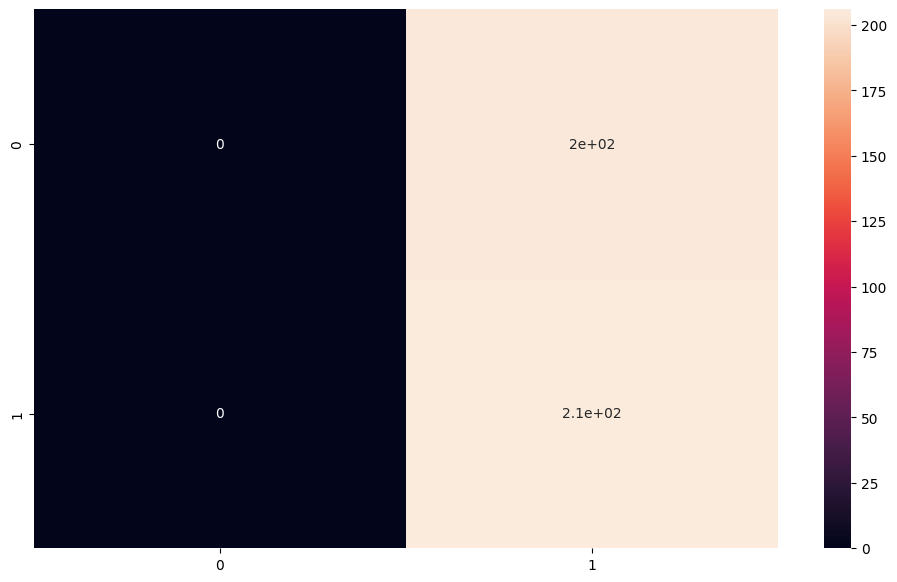

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

cf_matrix = confusion_matrix(actual_in_kfold[0], pred_in_kfold[0])

plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

<Axes: >

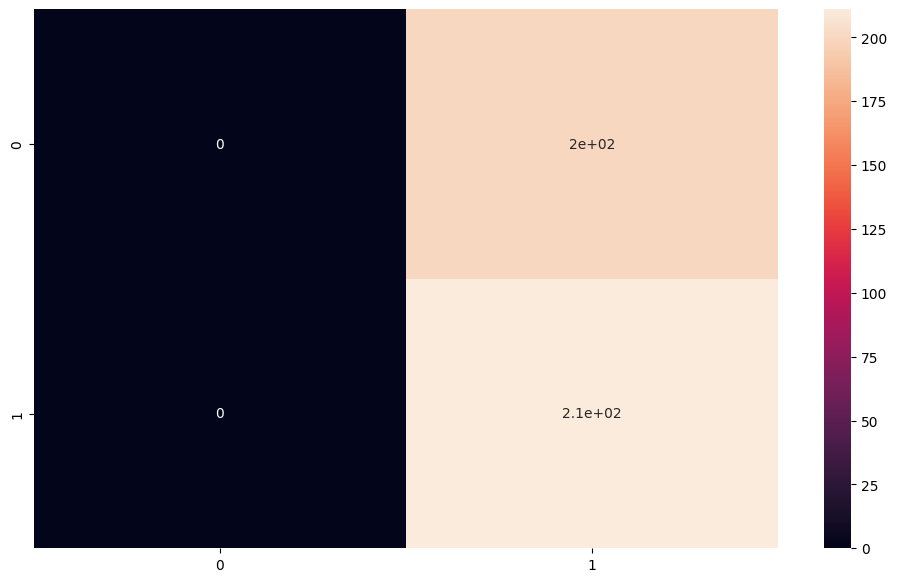

In [ ]:
cf_matrix = confusion_matrix(actual_in_kfold[1], pred_in_kfold[1])
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

<Axes: >

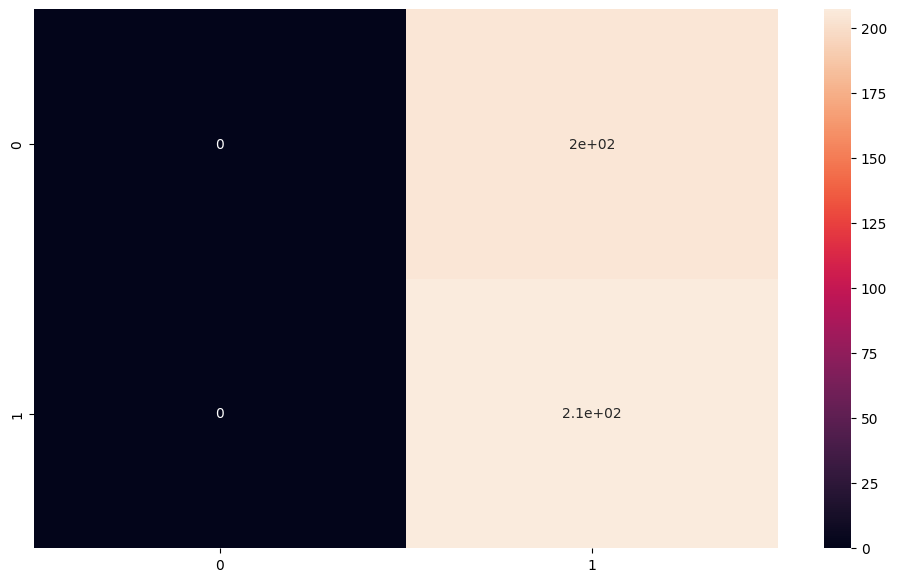

In [ ]:
cf_matrix = confusion_matrix(actual_in_kfold[2], pred_in_kfold[2])
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

<Axes: >

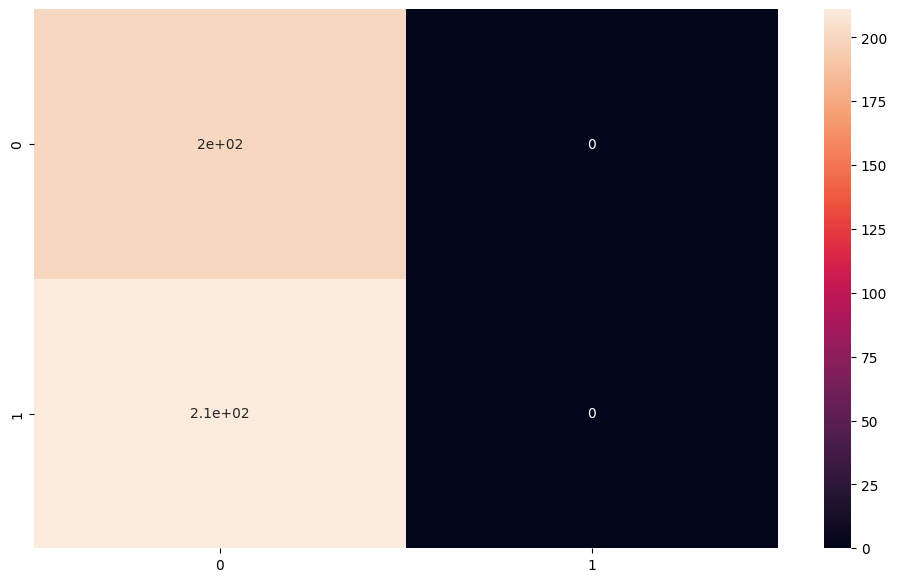

In [ ]:
cf_matrix = confusion_matrix(actual_in_kfold[3], pred_in_kfold[3])
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

<Axes: >

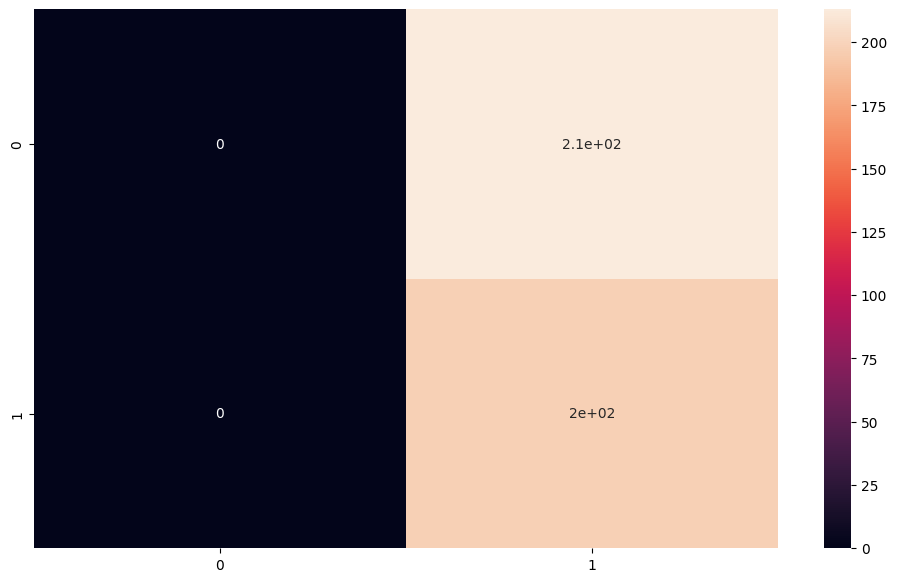

In [ ]:
cf_matrix = confusion_matrix(actual_in_kfold[4], pred_in_kfold[4])
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

<Axes: >

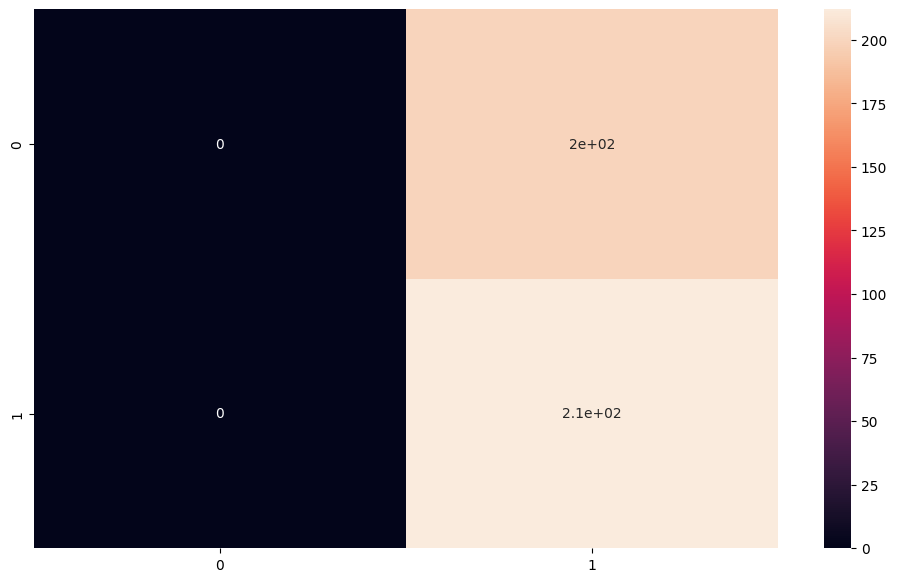

In [ ]:
cf_matrix = confusion_matrix(actual_in_kfold[5], pred_in_kfold[5])
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

<Axes: >

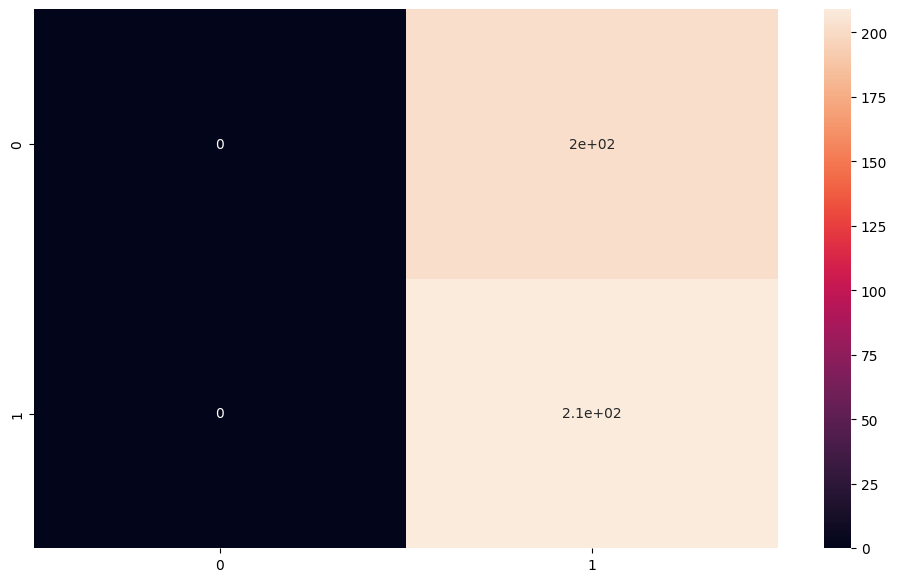

In [ ]:
cf_matrix = confusion_matrix(actual_in_kfold[6], pred_in_kfold[6])
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

<Axes: >

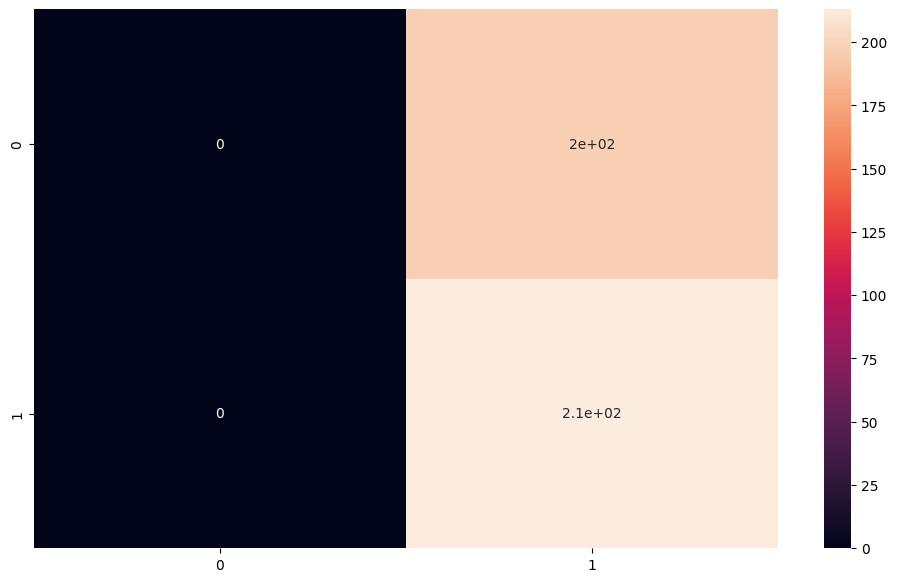

In [ ]:
cf_matrix = confusion_matrix(actual_in_kfold[7], pred_in_kfold[7])
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

<Axes: >

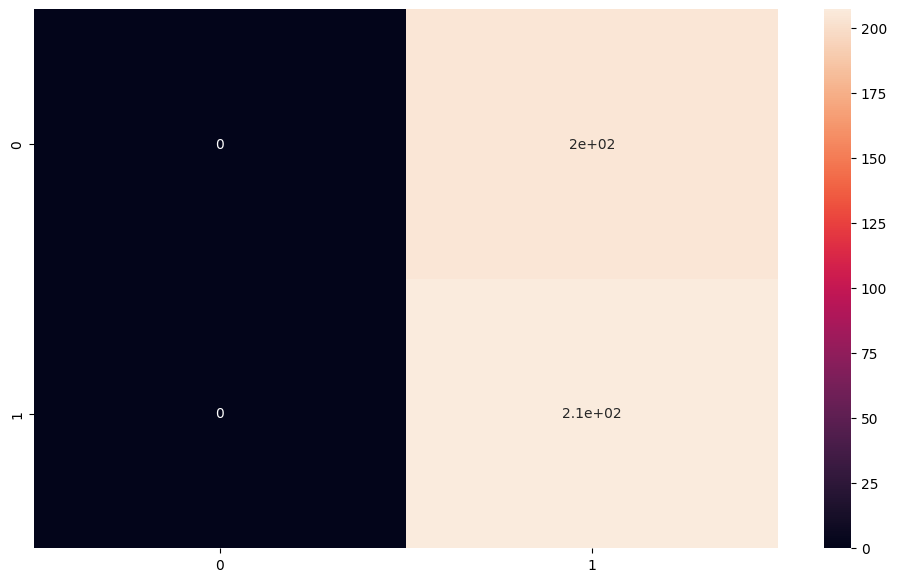

In [ ]:
cf_matrix = confusion_matrix(actual_in_kfold[8], pred_in_kfold[8])
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

<Axes: >

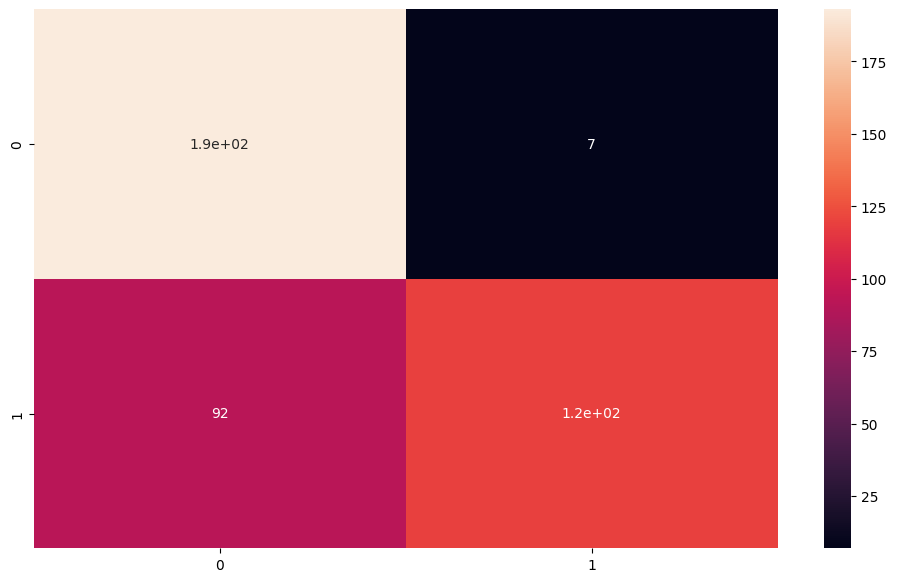

In [ ]:
cf_matrix = confusion_matrix(actual_in_kfold[9], pred_in_kfold[9])
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

In [ ]:
# # model_name = "Decision Tree"
# plot_result("BP NN",
#             "Accuracy",
#             "Accuracy scores in 5 Folds",
#             test_accuracy_values,
#             test_accuracy_values)

# [Viz] for the Average Accuracy per k-fold (bar chart)

In [ ]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str,
            Name of the algorithm used for training e.g 'Decision Tree'

         y_label: str,
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str,
            This is the title of the plot e.g 'Accuracy Plot'

         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.

         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''

        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
def Average(lst):
  return sum(lst) / len(lst)

In [ ]:
K = [1,2,3,4,5,6,7,8,9,10]
avg_accuracy = []
for i in all_test_accuracy:
  avg = Average(i)
  avg_accuracy.append(avg)

In [ ]:
print(avg_accuracy)

[50.12165450121633, 51.33819951338217, 50.36496350364953, 48.661800486617835, 48.17518248175169, 51.58150851581515, 50.85158150851569, 51.82481751824835, 50.36496350364953, 75.91240875912409]


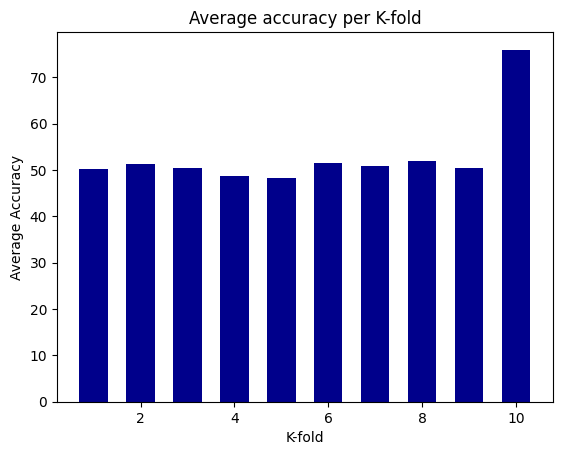

In [ ]:
plt.bar(K, avg_accuracy, color ='darkblue', width = 0.6)
plt.xlabel("K-fold")
plt.ylabel("Average Accuracy")
plt.title("Average accuracy per K-fold")
plt.show()

# PCF Calculations
- Recommended by the DOH: PCF Formula. Only a maximum number of facilities are allowed to be placed in a given area

## Computing for number of PCFs required

(Population Density)*(Land Area) = number of people

In [ ]:
sablayan_clustered_df.drop(sablayan_clustered_df.index[sablayan_clustered_df['Cluster'] == 1], inplace = True)

In [ ]:
total_sablayan_population = sablayan_clustered_df['POPULATION PER HEX'].sum()
print(total_sablayan_population)

106291.23723888009


In [ ]:
# df with RHUs + df with buildable areas == SABLAYAN
# using this to compute for the total population
frames = [hex_with_rhu, sablayan_clustered_df]
sablayan_with_rhu = pd.concat(frames)
sablayan_with_rhu

,Unnamed: 0,Unnamed: 0.1,id,BARANGAY,PSGC,LAND COVERAGE,RHU,POPULATION DENSITY PER HEXAGON,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,LANDCOVER NUMERICAL,TargetID,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster
16,16,18,93,Batong Buhay,PH175109002,Built Up,1,1590.110229,47,1,3,2,1.0,0,93,0.000000,11246.849650,0.720001,1
133,133,177,311,Pag-Asa,PH175109008,Built Up,1,203.314786,5,1,2,0,0.0,0,311,0.000000,1438.045483,0.328209,0
157,157,211,366,Burgos,PH175109011,barren,1,233.181617,0,1,0,3,3.0,0,366,0.000000,1649.293578,0.268943,0
2,4,4,51,San Agustin,PH175109004,Grassland,0,302.902705,0,0,3,1,0.0,1,93,10.820233,2142.430830,0.341248,0
3,11,12,88,Batong Buhay,PH175109004,Brush/Shrubs,0,168.775302,0,0,3,2,0.0,1,366,11.898864,1193.747713,0.297111,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,956,1380,1327,Burgos,PH175109003,Brush/Shrubs,0,8.342944,0,0,0,0,3.0,1,311,41.515148,59.009644,0.269663,0
411,957,1382,1328,Pag-Asa,PH175109003,Brush/Shrubs,0,9.566134,0,0,0,0,3.0,1,311,41.646111,67.661267,0.269663,0
412,964,1390,1359,Pag-Asa,PH175109008,Brush/Shrubs,0,8.042470,0,0,0,0,3.0,1,311,42.997136,56.884392,0.269663,0
413,965,1391,1360,Pag-Asa,PH175109008,Brush/Shrubs,0,8.922136,0,0,0,0,3.0,1,311,42.902044,63.106267,0.269663,0


## PCF Calculation proper

In [ ]:
def PCF(total_population):
  # percent = (population_no_access / total_population) * 100
  # PCF = population_no_access / 20000
  PCF = total_population / 20000
  return PCF

In [ ]:
print(PCF(total_sablayan_population))

5.3145618619440045


# Getting candidate sites
- Using low accessibility to get possible high accessible areas

In [ ]:
def low_k_fold_splitter(x,y,low_x,low_y):
  # unsure if we keep the split but i left it here
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

  # actual labels for testing
  y_test = low_y

  x_train_tensor = torch.tensor(x_train.values, dtype=torch.float)
  x_test_tensor = torch.tensor(low_x.values, dtype=torch.float)

  y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
  y_test_tensor = torch.tensor(low_y.values, dtype=torch.long)

  # Splits X and Y tensors
  train_data = TrainData(x_train_tensor, y_train_tensor)
  test_data = TestData(x_test_tensor, y_test_tensor)

  # Data Loader
  BATCH_SIZE = 64 # ✈️ GO BACK TO THIS NEXT SEM - something u can optimize pa
  train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(dataset=test_data, batch_size=1)


  return train_loader, test_loader, x_test_tensor, y_test

In [ ]:
global all_train_loss
all_train_loss = []

global all_test_average_loss_values
all_test_average_loss_values  = []

global all_test_accuracy
all_test_accuracy = []

global all_pred_per_kfold
all_pred_per_kfold = []

global all_actual_per_kfold
all_actual_per_kfold = []

global actual_in_kfold
actual_in_kfold = []

global pred_in_kfold
pred_in_kfold = []

global hexid_per_kfold
hexid_per_kfold = []

In [ ]:
filtered_low_accessible_x

,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,Distance in kilometers,POPULATION PER HEX,HCFAI,RHU,LANDCOVER NUMERICAL
2,0.000000,0.0,1.000000,0.333333,0.000000,0.251650,0.189406,0.160302,0,1
3,0.000000,0.0,1.000000,0.666667,0.000000,0.276736,0.104942,0.062451,0,1
4,0.000000,0.0,1.000000,1.000000,0.000000,0.153505,0.149629,0.038250,0,1
6,0.021277,1.0,1.000000,0.333333,0.666667,0.076753,0.112912,0.000634,0,1
7,0.000000,1.0,0.666667,0.333333,0.333333,0.038376,0.525751,0.065621,0,1
...,...,...,...,...,...,...,...,...,...,...
410,0.000000,0.0,0.000000,0.000000,1.000000,0.965533,0.003912,0.001598,0,1
411,0.000000,0.0,0.000000,0.000000,1.000000,0.968579,0.004683,0.001599,0,1
412,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.003723,0.001598,0,1
413,0.000000,0.0,0.000000,0.000000,1.000000,0.997788,0.004277,0.001599,0,1


In [ ]:
filtered_labels_y

2      0
3      0
4      0
6      0
7      0
      ..
410    0
411    0
412    0
413    0
414    0
Name: Cluster, Length: 411, dtype: int64

In [ ]:
for k in range(10):
  print(k)
  # train_loader, test_loader, x_test_tensor, y_test = k_fold_splitter(x_normalized, y_sample)
  train_loader, test_loader, x_test_tensor, y_test = low_k_fold_splitter(x_normalized, y_sample, filtered_low_accessible_x, filtered_labels_y)

  test_loss_values = []
  test_average_loss_values = []
  test_accuracy_values = []

  epochs = 100
  for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)

  # predictions per k-fold
  predictions = model(x_test_tensor)
  predictions = F.softmax(predictions)
  predictions = torch.argmax(predictions, dim=1)

  pred_in_kfold.append(predictions)

  # actual y values per k-fold
  actual_y = y_test

  # hexids per k-fold
  # hexid = y_test['id'].values

  #🌈 Appending small list to big list

  # loss
  all_train_loss.append(train_loss_values)
  all_test_average_loss_values.append(test_average_loss_values)

  # accuracy
  all_test_accuracy.append(test_accuracy_values)

  # y pred and actual y
  actual_in_kfold.append(actual_y)
  all_pred_per_kfold.append(pred_in_kfold)
  all_actual_per_kfold.append(actual_y.tolist())

  # # hexids
  # hexid_per_kfold.append(hexid.tolist())

  print("Done!")

Streaming output truncated to the last 5000 lines.
-------------------------------
0
1
2
3
4
5
6
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.691965 

Epoch 86
-------------------------------
0
1
2
3
4
5
6
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.691965 

Epoch 87
-------------------------------
0
1
2
3
4
5
6
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.691965 

Epoch 88
-------------------------------
0
1
2
3
4
5
6
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.691965 

Epoch 89
-------------------------------
0
1
2
3
4
5
6
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.691965 

Epoch 90
-------------------------------
0
1
2
3
4
5
6
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.691965 

Epoch 91
-------------------------------
0
1
2
3
4
5
6
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.691965 

Epoch 92
-------------------------------
0
1
2
3
4
5
6
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.691965 

Epoch 93
-------------------------------
0
1
2
3
4
5
6
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.6919

In [ ]:
# results['hex_id'] = hexid_per_kfold[0]
results = pd.DataFrame()
results['pred_y'] = all_pred_per_kfold[0][0]
results['actual_y'] = all_actual_per_kfold[0][0]

In [ ]:
results = pd.concat([results, y_filtered_labels_id], axis=1)

In [ ]:
results = results.drop(['index'], axis=1)

In [ ]:
results = results[results['pred_y'] == 1]
results

,pred_y,actual_y,id,Cluster
1,1,0,88,0
2,1,0,89,0
5,1,0,128,0
10,1,0,161,0
14,1,0,166,0
15,1,0,167,0
17,1,0,196,0
18,1,0,197,0
24,1,0,232,0
25,1,0,233,0


# Optimization function
- This is where we eliminate adjacent hexagons and find the optimal locations given candidate sites.
- This is also where we calculate the HCFAI of the entire Sablayan area.
- Given DOH's recommended PCF forumala for accessibility, we will be selecting a total of 7 locations (4 locations found by the model and 3 existing RHU locations)
- This process is repeated until all 7 locations are found.

- **Inputs:** Candidate points
- **Outputs:** Optimal points (with IDs)

## Optimized Algorithm

In [ ]:
# Function
def HCI_calc (total_ai, road_bi, POI_ci, landCov_di, hazard1_ei, hazard2_ei, hazard3_ei, distance):
    w_bi = 0.30
    w_ci = 0.25
    w_di = 0.30
    w_ei = 0.15

    # coverage
    y = 20000 / ((total_ai+1)*(distance+1))
    mc = y.apply(lambda x: m.tanh(x))

    # feasibility
    poi = POI_ci
    b = ((poi*w_ci) + (road_bi*w_bi) + (landCov_di*w_di))
    c = ((hazard1_ei+1*w_ei)) + ((hazard2_ei+1*w_ei)) + ((hazard3_ei+1*w_ei))

    f = (b-c)
    f = f.apply(lambda x: m.tanh(x))
    hci = (mc*f)

    hcfai = (hci.apply(lambda x: 1 + m.tanh(x/2)) / 2) # SIGMOID FXN

    return hcfai

In [ ]:
# Computing overall HCFAI using SUM
def overallHCFAI(sablayan_clustered_df):
  HCFAI_overall = sablayan_clustered_df.loc[:, 'HCFAI'].sum()
  return HCFAI_overall

In [ ]:
## Init top4, and add first candidate site to top 4 loop until len(top4) == 5
def getTop4(HCFAI_overall,candidate_sites, top4):
  # results_with_hcfai = results_with_hcfai.loc[:,['id', 'HCFAI']]
  # arrange and get top4.
  if top4.empty:
    candidate_sites = candidate_sites.merge(results, on=['id'])
    # arrange in descending order
    candidate_sites = candidate_sites.sort_values(by=['HCFAI'], ascending = False)
    # renamed HCFAI into "original HCFAI"
    candidate_sites = candidate_sites.rename(columns={"HCFAI": "original HCFAI"})
    top4 = candidate_sites.iloc[:5]
    candidate_sites.drop(candidate_sites.index[:5], inplace=True)

  elif len(top4) < 5: # if optimal and existing RHUs list is incomplete
    while len(top4) < 5:
      # append the first candidate site, to fill in the list
      new_site = candidate_sites.iloc[:1]
      top4 = pd.concat([top4, new_site], ignore_index = True)
      candidate_sites.drop(candidate_sites.index[0], inplace=True)

  return top4, candidate_sites

In [ ]:
def recomputeHCFAI(top4):
  # Getting column values to recompute updated HCFAI
  pop_den = top4.loc[:,"POPULATION PER HEX"]

  # top4.at[:, 'RHU'] = int('1')
  # change distance to 0, make it into a hex with a RHU
  top4['Distance in kilometers'] = 0

  road_exists = top4.loc[:,"ROADS"]
  no_of_pois = top4.loc[:,"POIs PER HEXAGON"]
  landcov_value = top4.loc[:,"LANDCOVER NUMERICAL"]
  stormsurge_level = top4.loc[:,"STORM SURGE HAZARD LEVEL"]
  flood_level = top4.loc[:,"FLOOD HAZARD LEVEL"]
  landslide_level = top4.loc[:,"LANDSLIDE HAZARD LEVEL"]
  distance_rhu = top4.loc[:,"Distance in kilometers"]

  # compute for new HCFAI where RHU = 1
  new_HCFAI = HCI_calc(pop_den, road_exists, no_of_pois, landcov_value, stormsurge_level, flood_level, landslide_level, distance_rhu)

  top4['new HCFAI'] = new_HCFAI
  return top4

In [ ]:
def updateOverallHCFAIValue(sablayan_clustered_df,top4):
  # copying column into updated HCFAI
  # sablayan_clustered_df['updated HCFAI'] = sablayan_clustered_df.loc[:, 'HCFAI']
  # automate getting indexes of top4
  # Using Series.values.tolist()
  indexes_top4 = top4.index.values.tolist()
  for i in indexes_top4:
    topHCFAI = top4.loc[i, 'new HCFAI']
    sablayan_clustered_df.loc[i, ['HCFAI']] = [topHCFAI]
    # used to be = [0]
  return sablayan_clustered_df

In [ ]:
  raw_sablayan_clustered_df = pd.read_csv(data_dir + 'HCFAI_Cluster_data.csv')
  raw_sablayan_clustered_df.rename(columns = {'HCFAI_y':'HCFAI'}, inplace = True)

In [ ]:
def getNeighbours(top4):
  neighbors_df = pd.read_csv(data_dir + 'neighbors_csv.csv')

  # List of ALL hexagons with RHUs
  with_RHU_indices = top4['id'].tolist()
  # add existing RHUs
  with_RHU_indices.append(93.0)
  with_RHU_indices.append(311.0)
  with_RHU_indices.append(366.0)

  raw_sablayan_clustered_df = pd.read_csv(data_dir + 'HCFAI_Cluster_data.csv')
  raw_sablayan_clustered_df.rename(columns = {'HCFAI_y':'HCFAI'}, inplace = True)

  # get index of with_RHU
  idx_with_RHU = raw_sablayan_clustered_df[raw_sablayan_clustered_df['Distance in kilometers'] == 0]

  # get specific rows of with_RHU in neighbor df
  df_with_RHU = pd.DataFrame()

  # making df candidate sites with neighbors because we have a list of ids
  # with RHU -- (candidates + rhu) so now, we need to get the dataframe WITH THE NEIGHBORS
  for i in range(len(with_RHU_indices)):
    o = neighbors_df[neighbors_df['id'] == with_RHU_indices[i]]
    if df_with_RHU.empty: # assumes no laman :>
      df_with_RHU = df_with_RHU.append(o)
    elif o['id'].values not in df_with_RHU['id'].values: # ids exist but we handle dups here
      # print(o['id'])
      df_with_RHU = df_with_RHU.append(o)

  # print("This is df_with_RHU ids ", df_with_RHU['id'].values)

  # neighbour data prep ( making neighbors standardized )
  neighbors_df['neighbours'] = neighbors_df['neighbours'].apply(lambda x: x.split(","))

  # 1. 'transform' dataframe
  neighbors_df = neighbors_df.explode('neighbours')
  neighbors_df['id'] = neighbors_df['id'].astype(int)
  neighbors_df['neighbours'] = neighbors_df['neighbours'].astype(float)

  df_with_RHU['neighbours'] = df_with_RHU['neighbours'].apply(lambda x: x.split(","))
  df_with_RHU = df_with_RHU.explode('neighbours')
  df_with_RHU['neighbours'] = df_with_RHU['neighbours'].astype(float)

  print(df_with_RHU)

  # removing adjacent ids
  for i in with_RHU_indices:
    if i in df_with_RHU['neighbours'].values:
      with_RHU_indices.remove(i)
      top4 = top4.drop(top4[top4['id'] == i].index)
      # find specific idx to remove from top 4

  return with_RHU_indices, top4

In [ ]:
def optimize(sablayan_df):
  raw_sablayan_clustered_df = pd.read_csv(data_dir + 'HCFAI_Cluster_data.csv')
  raw_sablayan_clustered_df.rename(columns = {'HCFAI_y':'HCFAI'}, inplace = True)
  # calculate overall HCFAI
  old_HCFAI_overall = overallHCFAI(raw_sablayan_clustered_df)
  print("Old Overall: ", old_HCFAI_overall)

  # this is the loop
  with_RHU_indices = list()
  top4 = pd.DataFrame()
  i=0

  # arrange in descending order (HCFAI)
  top4, candidate_sites = getTop4(old_HCFAI_overall, sablayan_df, top4)
  #### first round, len(top4) == 5

  while len(with_RHU_indices) != 8: # 3 existing RHUs + 4 possible candidate sites
    # get top 4 candidate sites, change RHU=1, recompute HCFAI
    top4 = recomputeHCFAI(top4)

    ## updating HCFAI values in main df, to recompute new HCFAI
    # call HCFAIoverall again to get the new HCFAI with candidate sites (top 4)
    sablayan_df = updateOverallHCFAIValue(raw_sablayan_clustered_df, top4)
    with_RHU_indices, top4 = getNeighbours(top4)
    #### adjacent locations are removed

    HCFAI_overall = overallHCFAI(sablayan_df)

    print("New Overall: [[OPTIMIZED]] ", HCFAI_overall)

     # ACCEPTS
    if len(with_RHU_indices) == 8:
      print("Accept!!!!!!!!!!!!!!")
      return with_RHU_indices, HCFAI_overall, old_HCFAI_overall

      # instead of sablayan_df, we load results_with_hcfai
      # drop top4 from sablayan cluster
    # REJECT condition
    else:
      top4, candidate_sites = getTop4(HCFAI_overall, candidate_sites, top4)
      print("Reject!!!!!!!!!!!!!!")
      print(with_RHU_indices)
      i+=1
      # if i == 15:
      #   return with_RHU_indices, HCFAI_overall, old_HCFAI_overall
  return with_RHU_indices, HCFAI_overall, old_HCFAI_overall

In [ ]:
optimal_locations, optimal_HCFAI, HCFAI_overall = optimize(sablayan_clustered_df)
print(optimal_locations)
print(optimal_HCFAI)

Old Overall:  265.2473107670559
      id  neighbours
48   161       125.0
48   161       126.0
48   161       160.0
48   161       162.0
48   161       195.0
48   161       196.0
11    88        87.0
11    88        89.0
12    89        88.0
12    89        90.0
183  406       371.0
183  406       372.0
183  406       405.0
183  406       407.0
86   232       196.0
86   232       197.0
86   232       231.0
86   232       233.0
86   232       267.0
16    93        58.0
16    93        92.0
16    93        94.0
132  311       275.0
132  311       276.0
132  311       310.0
132  311       312.0
132  311       345.0
132  311       346.0
156  366       330.0
156  366       331.0
156  366       367.0
156  366       400.0
156  366       401.0
New Overall: [[OPTIMIZED]]  265.1746427592905
Reject!!!!!!!!!!!!!!
[161, 89, 406, 232, 93.0, 311.0, 366.0]
      id  neighbours
48   161       125.0
48   161       126.0
48   161       160.0
48   161       162.0
48   161       195.0
48   161       196.0


## Randomizing locations vs. Our algorithm

In [ ]:
# Python program to get average of a list
def getAvgHCFAI(lst):
    return sum(lst) / len(lst)

In [ ]:
def getRandom4(candidate_sites):
  candidate_sites = candidate_sites.merge(results, on=['id']) # arrange in descending order
  candidate_sites = candidate_sites.rename(columns={"HCFAI": "original HCFAI"}) # renamed HCFAI into "original HCFAI"
  random4 = candidate_sites.sample(n=4)
  return random4

1. Get all candidate sites (and its ids)
2. Get random 4 candidate sites
3. Recompute overall HCFAI
4. do this 10 times
5. Get the avg HCFAI of the 10 times
6. compare with optimized HCFAI

In [ ]:
def randomize(sablayan_df):
  # use clustered to get top 4
  # use raw for the overall
  raw_sablayan_clustered_df = pd.read_csv(data_dir + 'HCFAI_Cluster_data.csv')
  raw_sablayan_clustered_df.rename(columns = {'HCFAI_y':'HCFAI'}, inplace = True)

  HCFAI_overall = overallHCFAI(raw_sablayan_clustered_df)
  print("=========== Overall HCFAI (before) ============ ", HCFAI_overall)

  # get the list of ids of predicted locations
  random4 = getRandom4(sablayan_df)
  random4 = recomputeHCFAI(random4)
  sablayan_df = updateOverallHCFAIValue(raw_sablayan_clustered_df, random4)
  HCFAI_overall = overallHCFAI(sablayan_df)
  rdm4_list = random4['id'].tolist()
  # print("This is random4: ", random4['id'].tolist())
  # print("This is random4's HCFAI: ", random4['updated HCFAI'].tolist())
  print("=========== Overall HCFAI (after) ============ ", HCFAI_overall)

  return HCFAI_overall, rdm4_list

In [ ]:
sablayan_clustered_df

,Unnamed: 0,Unnamed: 0.1,id,BARANGAY,PSGC,LAND COVERAGE,RHU,POPULATION DENSITY PER HEXAGON,POIs PER HEXAGON,ROADS,STORM SURGE HAZARD LEVEL,FLOOD HAZARD LEVEL,LANDSLIDE HAZARD LEVEL,LANDCOVER NUMERICAL,TargetID,Distance in kilometers,POPULATION PER HEX,HCFAI,Cluster
2,4,4,51,San Agustin,PH175109004,Grassland,0,302.902705,0,0,3,1,0.0,1,93,10.820233,2142.430830,0.341248,0
3,11,12,88,Batong Buhay,PH175109004,Brush/Shrubs,0,168.775302,0,0,3,2,0.0,1,366,11.898864,1193.747713,0.297111,0
4,12,14,89,Malisbong,PH175109004,Brush/Shrubs,0,239.737270,0,0,3,3,0.0,1,93,6.600283,1695.661709,0.286195,0
6,18,21,95,Pag-Asa,PH175109009,Brush/Shrubs,0,181.431633,1,1,3,1,2.0,1,93,3.300142,1283.265940,0.269228,0
7,32,40,127,Batong Buhay,PH175109019,Brush/Shrubs,0,837.013031,0,1,2,1,1.0,1,93,1.650071,5920.193168,0.298541,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,956,1380,1327,Burgos,PH175109003,Brush/Shrubs,0,8.342944,0,0,0,0,3.0,1,311,41.515148,59.009644,0.269663,0
411,957,1382,1328,Pag-Asa,PH175109003,Brush/Shrubs,0,9.566134,0,0,0,0,3.0,1,311,41.646111,67.661267,0.269663,0
412,964,1390,1359,Pag-Asa,PH175109008,Brush/Shrubs,0,8.042470,0,0,0,0,3.0,1,311,42.997136,56.884392,0.269663,0
413,965,1391,1360,Pag-Asa,PH175109008,Brush/Shrubs,0,8.922136,0,0,0,0,3.0,1,311,42.902044,63.106267,0.269663,0


In [ ]:
rdm_hcfai = list()
rdm_points = list()
repeat = 0
while repeat < 10:
  rdm_ovHCFAI, rdm4 = randomize(sablayan_clustered_df)
  rdm_hcfai.append(rdm_ovHCFAI)
  rdm_points.append(rdm4)
  repeat+=1

print(len(rdm_hcfai))
rdm_HCFAI = getAvgHCFAI(rdm_hcfai)
print("New avg hcfai [[RANDOM]]: ", rdm_HCFAI)

=========== Overall HCFAI (before) ============  265.2473107670559
=========== Overall HCFAI (after) ============  264.7442575899522
=========== Overall HCFAI (before) ============  265.2473107670559
=========== Overall HCFAI (after) ============  265.20810974362416
=========== Overall HCFAI (before) ============  265.2473107670559
=========== Overall HCFAI (after) ============  265.13680532003457
=========== Overall HCFAI (before) ============  265.2473107670559
=========== Overall HCFAI (after) ============  265.08659894494497
=========== Overall HCFAI (before) ============  265.2473107670559
=========== Overall HCFAI (after) ============  264.77707361994413
=========== Overall HCFAI (before) ============  265.2473107670559
=========== Overall HCFAI (after) ============  265.11279937361564
=========== Overall HCFAI (before) ============  265.2473107670559
=========== Overall HCFAI (after) ============  264.6940713469653
=========== Overall HCFAI (before) ============  265.24731076705

In [ ]:
print("=========== RANDOM RESULTS ===========")
print("RANDOMIZED HCFAI: ", rdm_HCFAI)
print("============ OPTIMIZED RESULTS ==========")
print("Optimal locations: ", optimal_locations)
print("OPTIMAL HCFAI: ", optimal_HCFAI)

=========== RANDOM RESULTS ===========
RANDOMIZED HCFAI:  265.02227657010013
============ OPTIMIZED RESULTS ==========
Optimal locations:  [161, 89, 406, 232, 267, 93.0, 311.0, 366.0]
OPTIMAL HCFAI:  265.0755604942561


In [ ]:
## making a df of all random points
Results_rdmsum =  pd.DataFrame(
    {'Hex IDs': rdm_points,
     'HCFAI': rdm_hcfai
    })
Results_rdmsum

,Hex IDs,HCFAI
0,"[233, 348, 406, 269]",264.744258
1,"[337, 233, 374, 197]",265.208110
2,"[89, 232, 347, 369]",265.136805
3,"[167, 302, 161, 128]",265.086599
4,"[348, 374, 267, 197]",264.777074
5,"[89, 337, 267, 347]",265.112799
6,"[166, 348, 337, 267]",264.694071
7,"[166, 269, 337, 369]",265.128256
8,"[196, 233, 88, 302]",265.190564
9,"[374, 303, 347, 406]",265.144229


## Computing overall HCFAI using AVG -- USING OPTIMIZED ALGORITHM

In [ ]:
# Computing overall HCFAI using AVG
def overallHCFAI_avg(sablayan_clustered_df):
  HCFAI_overall = sablayan_clustered_df.loc[:, 'HCFAI'].mean()
  return HCFAI_overall

In [ ]:
def optimize(sablayan_df):
  raw_sablayan_clustered_df = pd.read_csv(data_dir + 'HCFAI_Cluster_data.csv')
  raw_sablayan_clustered_df.rename(columns = {'HCFAI_y':'HCFAI'}, inplace = True)

  # calculate overall HCFAI
  old_HCFAI_overall_avg = overallHCFAI_avg(raw_sablayan_clustered_df)
  print("Old Overall: ", old_HCFAI_overall_avg)

  # this is the loop
  with_RHU_indices = list()
  top4 = pd.DataFrame()
  i=0

  # arrange in descending order (HCFAI)
  top4, candidate_sites = getTop4(old_HCFAI_overall_avg, sablayan_df, top4)
  while len(with_RHU_indices) != 7: # 3 existing RHUs + 4 possible candidate sites
  # while i < 5: # 3 existing RHUs + 4 possible candidate sites

    # get top 4 candidate sites, change RHU=1, recompute HCFAI
    top4 = recomputeHCFAI(top4)
    # call HCFAIoverall again to get the new HCFAI with candidate sites (top 4)
    sablayan_df = updateOverallHCFAIValue(raw_sablayan_clustered_df, top4)

    with_RHU_indices, top4 = getNeighbours(top4)
    HCFAI_overall_avg = overallHCFAI_avg(sablayan_df)
    print("New Overall: [[OPTIMIZED]] ", HCFAI_overall_avg)

    # ACCEPTS
    if len(with_RHU_indices) == 7:
      print("Accept!!!!!!!!!!!!!!")
      return with_RHU_indices, HCFAI_overall_avg, old_HCFAI_overall_avg
      # instead of sablayan_df, we load results_with_hcfai
      # drop top4 from sablayan cluster

    # REJECT condition
    else:
      top4, candidate_sites = getTop4(HCFAI_overall_avg, candidate_sites,top4)
      print("Reject!!!!!!!!!!!!!!")
      i+=1

      if i == 15:
          return with_RHU_indices, HCFAI_overall_avg, old_HCFAI_overall_avg
  return with_RHU_indices, HCFAI_overall_avg, old_HCFAI_overall_avg

In [ ]:
optimal_locations_avg, optimal_HCFAI_avg, HCFAI_overall_avg = optimize(sablayan_clustered_df)
print(optimal_locations_avg)
print(optimal_HCFAI_avg)

Old Overall:  0.2742991838335635
      id  neighbours
48   161       125.0
48   161       126.0
48   161       160.0
48   161       162.0
48   161       195.0
48   161       196.0
11    88        87.0
11    88        89.0
12    89        88.0
12    89        90.0
183  406       371.0
183  406       372.0
183  406       405.0
183  406       407.0
86   232       196.0
86   232       197.0
86   232       231.0
86   232       233.0
16    93        58.0
16    93        92.0
16    93        94.0
132  311       275.0
132  311       276.0
132  311       310.0
132  311       312.0
132  311       345.0
132  311       346.0
156  366       330.0
156  366       331.0
156  366       367.0
156  366       400.0
156  366       401.0
New Overall: [[OPTIMIZED]]  0.2742240359454918
Accept!!!!!!!!!!!!!!
[161, 89, 406, 232, 93.0, 311.0, 366.0]
0.2742240359454918


## Computing overall HCFAI using AVG -- USING RANDOM

In [ ]:
def randomize_avg(sablayan_df):
  # use clustered to get top 4
  # use raw for the overall
  raw_sablayan_clustered_df = pd.read_csv(data_dir + 'HCFAI_Cluster_data.csv')
  raw_sablayan_clustered_df.rename(columns = {'HCFAI_y':'HCFAI'}, inplace = True)

  HCFAI_overall = overallHCFAI_avg(raw_sablayan_clustered_df)
  print("=========== Overall HCFAI (before) ============ ", HCFAI_overall)

  # get the list of ids of predicted locations
  random4 = getRandom4(sablayan_df)
  random4 = recomputeHCFAI(random4)
  sablayan_df = updateOverallHCFAIValue(raw_sablayan_clustered_df, random4)
  HCFAI_overall = overallHCFAI_avg(sablayan_df)
  rdm4_list = random4['id'].tolist()
  # print("This is random4: ", random4['id'].tolist())
  # print("This is random4's HCFAI: ", random4['updated HCFAI'].tolist())
  print("=========== Overall HCFAI (after) ============ ", HCFAI_overall)

  return HCFAI_overall, rdm4_list

In [ ]:
rdm_hcfai = list()
rdm_points = list()
repeat = 0
while repeat < 10:
  rdm_ovHCFAI, rdm4 = randomize_avg(sablayan_clustered_df)
  rdm_hcfai.append(rdm_ovHCFAI)
  rdm_points.append(rdm4)
  repeat+=1


print(len(rdm_hcfai))
rdm_HCFAI_avg = getAvgHCFAI(rdm_hcfai)
print("New avg hcfai [[RANDOM]]: ", rdm_HCFAI_avg)

=========== Overall HCFAI (before) ============  0.2742991838335635
=========== Overall HCFAI (after) ============  0.27419990254683313
=========== Overall HCFAI (before) ============  0.2742991838335635
=========== Overall HCFAI (after) ============  0.2741817200683352
=========== Overall HCFAI (before) ============  0.2742991838335635
=========== Overall HCFAI (after) ============  0.27416527442727445
=========== Overall HCFAI (before) ============  0.2742991838335635
=========== Overall HCFAI (after) ============  0.27379804415429015
=========== Overall HCFAI (before) ============  0.2742991838335635
=========== Overall HCFAI (after) ============  0.2741504964525985
=========== Overall HCFAI (before) ============  0.2742991838335635
=========== Overall HCFAI (after) ============  0.2742639339788099
=========== Overall HCFAI (before) ============  0.2742991838335635
=========== Overall HCFAI (after) ============  0.27402677333659703
=========== Overall HCFAI (before) ============  0.

In [ ]:
Results_rdmavg =  pd.DataFrame(
    {'Hex IDs': rdm_points,
     'HCFAI': rdm_hcfai
    })
Results_rdmavg

,Hex IDs,HCFAI
0,"[303, 269, 167, 232]",0.274200
1,"[374, 337, 128, 166]",0.274182
2,"[337, 267, 232, 347]",0.274165
3,"[89, 232, 348, 269]",0.273798
4,"[269, 161, 167, 232]",0.274150
5,"[232, 369, 196, 128]",0.274264
6,"[167, 347, 269, 166]",0.274027
7,"[89, 348, 337, 369]",0.273808
8,"[302, 348, 161, 337]",0.273748
9,"[348, 233, 374, 347]",0.273705


In [ ]:
print("=========== RANDOM RESULTS ===========")
print("RANDOMIZED HCFAI: ", rdm_HCFAI_avg)
print("============ OPTIMIZED RESULTS ==========")
print("Optimal locations: ", optimal_locations)
print("OPTIMAL HCFAI: ", optimal_HCFAI_avg)

=========== RANDOM RESULTS ===========
RANDOMIZED HCFAI:  0.2740047726416424
============ OPTIMIZED RESULTS ==========
Optimal locations:  [161, 89, 406, 232, 267, 93.0, 311.0, 366.0]
OPTIMAL HCFAI:  0.2742240359454918


# Preparing the tables for results

In [ ]:
 ''' Put in list
 1. OLD HCFAIs
 2. NEW HCFAIs Random
 3. NEW HCFAIs Our Algorithm
 '''

old_hcfai = []
old_hcfai.append(HCFAI_overall)
old_hcfai.append(HCFAI_overall_avg)

rdmHCFAI = []
rdmHCFAI.append(rdm_HCFAI)
rdmHCFAI.append(rdm_HCFAI_avg)

opt_HCFAI = []
opt_HCFAI.append(optimal_HCFAI)
opt_HCFAI.append(optimal_HCFAI_avg)

In [ ]:
Results_1 =  pd.DataFrame(
    {' ': ['SUM', "AVG"],
    'Old HCFAI': old_hcfai,
     'Randomized HCFAI': rdmHCFAI,
     'Algorithm HCFAI': opt_HCFAI
    })

In [ ]:
Results_1

,,Old HCFAI,Randomized HCFAI,Algorithm HCFAI
0,SUM,265.247311,265.034770,265.075560
1,AVG,0.274299,0.274028,0.274224


In [ ]:
print('old', old_hcfai)
print('rdm', rdmHCFAI)
print('opt', opt_HCFAI)

old [265.2473107670559, 0.2742991838335635]
rdm [265.03477030552574, 0.27402811204672617]
opt [265.0755604942561, 0.2742240359454918]


# Visualization for Results
- old HCFAI
- Randomized HCFAI
- Algorithm HCFAI

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
Results_1.iloc[[0]]
Results_1.iloc[[1]]

,,Old HCFAI,Randomized HCFAI,Algorithm HCFAI
1,AVG,0.274299,0.274259,0.274482


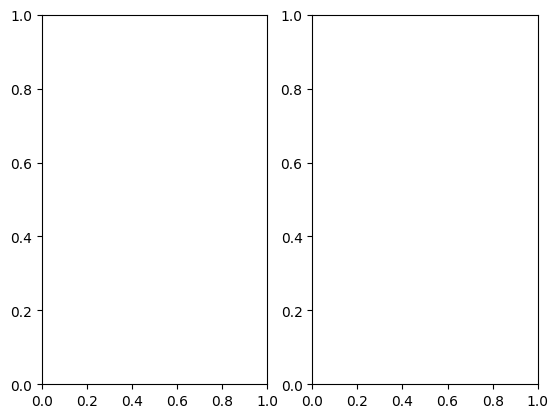

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

<Axes: >

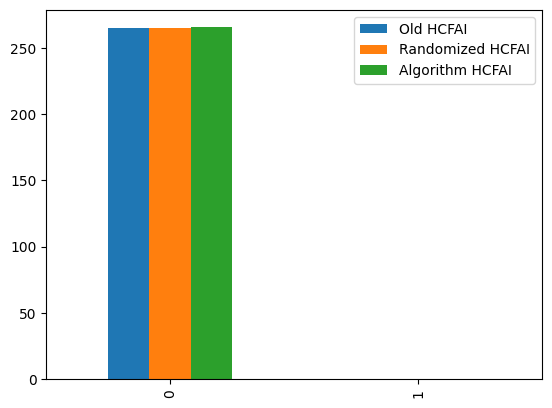

In [ ]:
# Results_1.iloc[[0,1],[0,1]].plot(kind="bar")
Results_1.iloc[[0,1]].plot(kind="bar")

Text(0.5, 1.0, 'Average results')

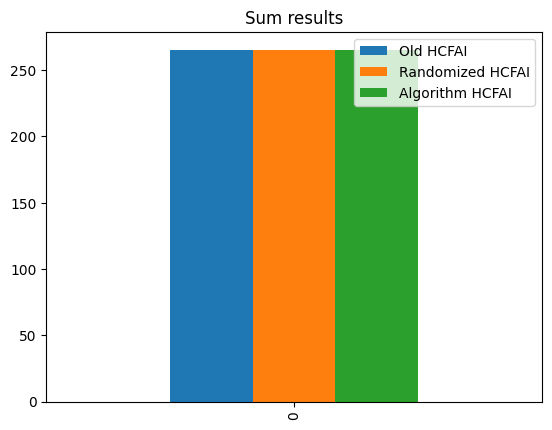

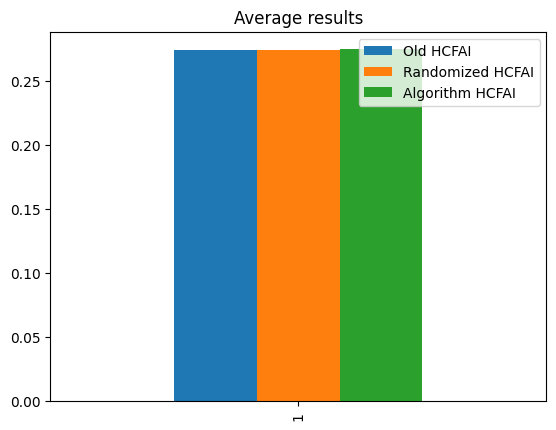

In [ ]:
sum_df = Results_1.iloc[[0]].plot(kind="bar")
sum_df.set_title('Sum results')
# Results_1.iloc[[0]].set_xticks(ind+width)
# viol_plot.set_xticklabels( ('A', 'B','C') )
avg_df = Results_1.iloc[[1]].plot(kind="bar")
avg_df.set_title('Average results')